This is a self-contained notebook to re-produce the experiments. The original code has been modified in some cases to be easier to re-produce and log. 

As a first step, create a .env at the root folder and specify the root path. This can be done through
```mv .env.defaults .env```
 and specify ```
PROJECT_PATH```
 in ```
.env```


# IMPORTANT

You don't have to run the cells that do not contain Python code (essentially these are the cells that start with !), these are cells that perform the whole pipeline of the project. You can run them if you want to full reproduce the results, they are configured to work without any need for change 🤞. Note that this proceess will require a lot of time and a GPU.

However, you can easily download all the models' checkpoints and files to visualize the results by downloading them from huggingface, the repo is configured to detect them automatically.

In [ ]:
!huggingface-cli download ApostolosK/chemflow-assets --include "ChemFlow/*" --local-dir .

The first script generates a dataset of 110,000 synthetic molecular structures (SMILES strings) using a pretrained Variational Autoencoder (VAE). 

It computes chemical properties like penalized logP, QED, and synthetic accessibility, or binding affinities for specific proteins, processing data in batches and using parallel computation. The generated molecular representations and properties are saved to a PyTorch file and a CSV file.

The current setup saves the two generated files at data/interim/props


In [ ]:
!python -m ChemFlow.experiments.prepare_random_data

The next script will train the predictors for each prop. You can set your wandb for logging in experiments/supervised/train_prop_predictor.sh

It will have extensive logging, but I believe this is needed to see if everything was executed correctly, so I kept it. 

The checkpoints for the different prop predictors will be stored at ChemFlow/checkpoints/prop_predictor

In [ ]:
!bash ChemFlow/experiments/supervised/train_prop_predictor.sh

The following cell will Train the energy network with supervised semantic guidance

The output will be located at checkpoints/wavepde_prop

Make sure to change the wandb entity in the .sh below

In [ ]:
!bash ChemFlow/experiments/supervised/train_wavepde_prop.sh

Train the energy network with unsupervised diversity guidance

The output model will be stored at checkpoints/wavepde

In [ ]:
!python -m ChemFlow.experiments.train_wavepde

Compute the pearson correlation coefficient

In [ ]:
!python -m ChemFlow.experiments.unsupervised.corr

In [2]:
csv_file_path = "ChemFlow/data/interim/corr/wave_unsup_0.1.csv" 

use_binding_affinity = False 
# --- End Configuration ---
import os
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from pathlib import Path
from collections import defaultdict
import warnings
import sys
from IPython.display import display, Markdown

# Suppress specific warnings if needed (e.g., from pearsonr with constant input)
warnings.filterwarnings("ignore", message="An input array is constant; the correlation coefficient is not defined.")

# Define the property sets
PROPS_STANDARD = ["plogp", "sa", "qed", "drd2", "jnk3", "gsk3b", "uplogp"]
PROPS_BINDING = ["1err", "2iik"]

def calculate_correlation_for_group(group: pd.DataFrame, props: list) -> pd.Series:
    """
    Calculates the Pearson correlation between time step 't' and
    each property for a given trajectory group.

    Args:
        group: DataFrame subset for a specific (k_idx, idx) pair.
        props: List of property column names to calculate correlation for.

    Returns:
        A pandas Series containing the correlation coefficient for each property.
        Returns NaN for a property if correlation cannot be calculated.
    """
    results = {}
    # Ensure 't' is sorted if not already, though groupby usually preserves order from source
    group = group.sort_values('t')
    time_steps = group['t'].values

    if len(time_steps) < 2: # Need at least 2 points for correlation
        for prop in props:
            results[prop] = np.nan
        return pd.Series(results)

    for prop in props:
        prop_values = group[prop].values
        # Check for constant values or insufficient data points
        if len(prop_values) < 2 or np.std(prop_values) < 1e-9: # Check standard deviation
             results[prop] = np.nan
        else:
            try:
                # Calculate correlation between time steps (e.g., 0..9) and property values
                correlation, _ = pearsonr(time_steps, prop_values)
                results[prop] = correlation if not np.isnan(correlation) else np.nan
            except ValueError: # Should be caught by std check, but just in case
                results[prop] = np.nan

    return pd.Series(results)

def find_best_indices(csv_path: str, binding_affinity: bool) -> (dict, pd.DataFrame):
    """
    Loads the correlation data CSV, calculates correlations, finds the best
    k_idx for each property, and returns the result as a dictionary
    along with the mean correlations DataFrame.

    Args:
        csv_path: Path to the CSV file generated by corr.py.
        binding_affinity: True if binding affinity properties were calculated,
                          False otherwise.

    Returns:
        A tuple containing:
          - A dictionary mapping property names to the best k_idx.
          - A DataFrame with the mean correlations per k_idx.
        Returns (None, None) if an error occurs.
    """
    csv_file = Path(csv_path)
    if not csv_file.is_file():
        print(f"❌ Error: CSV file not found at {csv_path}", file=sys.stderr)
        return None, None

    print(f"🔄 Loading data from: {csv_path}")
    try:
        df = pd.read_csv(csv_file, index_col=0)
        print(f"✅ Loaded DataFrame shape: {df.shape}")
        # display(df.head()) # Optional: uncomment to see the head
    except Exception as e:
        print(f"❌ Error loading CSV file: {e}", file=sys.stderr)
        return None, None

    # Determine which properties to analyze
    props_to_analyze = PROPS_BINDING if binding_affinity else PROPS_STANDARD
    print(f"📊 Analyzing properties: {props_to_analyze}")

    # Verify required columns exist
    required_cols = ['k_idx', 'idx', 't'] + props_to_analyze
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"❌ Error: Missing required columns in CSV: {missing_cols}", file=sys.stderr)
        print(f"❓ Did you run corr.py with the correct '--binding_affinity' setting ({binding_affinity})?", file=sys.stderr)
        return None, None
    print("🔄 Calculating correlations for each trajectory (k_idx, idx)...")
    try:
        from pandarallel import pandarallel
        pandarallel.initialize(nb_workers=os.cpu_count(), progress_bar=False, verbose=0) # Safe to call multiple times
        apply_method = df.groupby(['k_idx', 'idx']).parallel_apply
        print("   (Using pandarallel)")
    except ImportError:
        print("   (Pandarallel not found, using standard apply - may be slow)")
        apply_method = df.groupby(['k_idx', 'idx']).apply

    correlations = apply_method(
        calculate_correlation_for_group, props=props_to_analyze
    )

    # Filter out potential all-NaN groups if apply returned them
    correlations.dropna(how='all', inplace=True)

    if correlations.empty:
        print("❌ Error: No valid correlations could be calculated. Check input data and properties.", file=sys.stderr)
        return None, None

    print("🔄 Calculating mean correlations per k_idx...")
    # Group by k_idx and find the mean correlation across all trajectories for that k_idx
    mean_correlations = correlations.groupby('k_idx')[props_to_analyze].mean() # Select only props columns before mean

    # Fill any remaining NaNs (e.g., if a k_idx had only invalid trajectories) with 0
    mean_correlations.fillna(0, inplace=True)

    print("\n📋 Mean Correlations per k_idx:")
    display(mean_correlations)

    print("\n🔄 Calculating best k_idx for each property (based on max absolute correlation)...")
    # Calculate absolute correlations
    abs_mean_correlations = mean_correlations.abs()

    # Find the k_idx (index) corresponding to the maximum absolute correlation for each property (column)
    best_indices = abs_mean_correlations.idxmax()

    print("\n🏆 Best k_idx found:")
    display(best_indices.to_frame(name='Best k_idx'))

    return best_indices.to_dict(), mean_correlations

def format_dict_for_code(result_dict: dict) -> str:
    """Formats the dictionary nicely for pasting into Python code."""
    if not result_dict:
        return "{}"
    lines = ["{"]
    # Sort items for consistent output (optional)
    sorted_items = sorted(result_dict.items())
    for key, value in sorted_items:
        lines.append(f'    "{key}": {value},')
    lines.append("}")
    return "\n".join(lines)

# --- Run the analysis ---
best_k_indices_dict, mean_correlations_df = find_best_indices(csv_file_path, use_binding_affinity)

# --- Display the result ---
if best_k_indices_dict:
    display(Markdown("---"))
    display(Markdown("**Best `k_idx` mapping dictionary:**"))
    display(Markdown("Copy and paste this into the appropriate MAP in `experiments/utils/traversal_step.py`"))
    display(Markdown("---"))
    # Print the dictionary in a format easy to copy
    print(format_dict_for_code(best_k_indices_dict))
    display(Markdown("---"))
else:
    print("❌ Analysis failed. Please check the error messages above.")

🔄 Loading data from: ChemFlow/data/interim/corr/wave_unsup_0.1.csv
✅ Loaded DataFrame shape: (100000, 12)
📊 Analyzing properties: ['plogp', 'sa', 'qed', 'drd2', 'jnk3', 'gsk3b', 'uplogp']
🔄 Calculating correlations for each trajectory (k_idx, idx)...
   (Using pandarallel)
🔄 Calculating mean correlations per k_idx...

📋 Mean Correlations per k_idx:


,plogp,sa,qed,drd2,jnk3,gsk3b,uplogp
k_idx,,,,,,,
0,-0.002975,-0.004725,-0.003674,0.024355,0.023142,-0.010233,0.029134
1,0.008136,-0.032025,-0.008560,0.025166,0.006753,-0.028918,0.067936
2,0.016134,0.008053,0.012332,0.028598,0.018656,-0.010438,0.032703
3,0.023399,0.022573,-0.010237,0.023322,-0.002295,0.014903,0.004804
4,0.002360,0.015832,0.002642,-0.005333,-0.016061,-0.025026,0.009768
5,0.001941,0.022470,0.016017,-0.005298,0.007224,-0.026228,0.031234
6,0.010143,-0.028732,0.067395,-0.002777,-0.019771,-0.023012,0.064095
7,0.022018,0.003450,0.001336,0.016611,0.021571,-0.019142,0.038507
8,0.011089,-0.000748,-0.009207,0.022914,-0.002373,-0.029472,0.024719



🔄 Calculating best k_idx for each property (based on max absolute correlation)...

🏆 Best k_idx found:


,Best k_idx
plogp,9
sa,9
qed,6
drd2,2
jnk3,0
gsk3b,8
uplogp,1


---

**Best `k_idx` mapping dictionary:**

Copy and paste this into the appropriate MAP in `experiments/utils/traversal_step.py`

---

{
    "drd2": 2,
    "gsk3b": 8,
    "jnk3": 0,
    "plogp": 9,
    "qed": 6,
    "sa": 9,
    "uplogp": 1,
}


---

With this above we got the indices for wave pde. We want to do the same for hj_unsup. To do that, we need to edit in-place the corr.py line 31 and re-run. Also, first traine the hj model



In [ ]:
!python -m ChemFlow.experiments.train_wavepde --model.pde_function hj

In [ ]:
!python -m ChemFlow.experiments.unsupervised.corr --method hj_unsup


In [3]:
csv_file_path = "ChemFlow/data/interim/corr/hj_unsup_0.1.csv" 

use_binding_affinity = False 

best_k_indices_dict, mean_correlations_df = find_best_indices(csv_file_path, use_binding_affinity)

# --- Display the result ---
if best_k_indices_dict:
    display(Markdown("---"))
    display(Markdown("**Best `k_idx` mapping dictionary:**"))
    display(Markdown("Copy and paste this into the appropriate MAP in `experiments/utils/traversal_step.py`"))
    display(Markdown("---"))
    # Print the dictionary in a format easy to copy
    print(format_dict_for_code(best_k_indices_dict))
    display(Markdown("---"))
else:
    print("❌ Analysis failed. Please check the error messages above.")

🔄 Loading data from: ChemFlow/data/interim/corr/hj_unsup_0.1.csv
✅ Loaded DataFrame shape: (100000, 12)
📊 Analyzing properties: ['plogp', 'sa', 'qed', 'drd2', 'jnk3', 'gsk3b', 'uplogp']
🔄 Calculating correlations for each trajectory (k_idx, idx)...
   (Using pandarallel)
🔄 Calculating mean correlations per k_idx...

📋 Mean Correlations per k_idx:


,plogp,sa,qed,drd2,jnk3,gsk3b,uplogp
k_idx,,,,,,,
0,0.100063,-0.264589,0.312847,-0.207715,-0.103233,-0.165283,0.380999
1,0.109219,-0.245072,0.173280,-0.212454,-0.097415,-0.165358,0.312019
2,0.115744,-0.379317,0.315582,-0.166805,-0.148770,-0.219049,0.486597
3,0.004018,-0.031678,0.007175,0.021101,-0.015395,-0.029828,-0.002539
4,-0.021478,-0.008729,0.207988,-0.072907,-0.079255,-0.015099,0.102165
5,0.032483,-0.238833,0.363127,-0.093270,-0.080534,-0.124353,0.420318
6,0.048200,0.016905,-0.027426,0.052943,-0.029358,-0.054390,0.044048
7,0.064343,-0.257312,0.419164,-0.170422,-0.102255,-0.171788,0.484602
8,-0.010319,0.005989,0.148722,-0.084167,-0.048704,0.041201,0.073444



🔄 Calculating best k_idx for each property (based on max absolute correlation)...

🏆 Best k_idx found:


,Best k_idx
plogp,9
sa,9
qed,7
drd2,9
jnk3,9
gsk3b,9
uplogp,9


---

**Best `k_idx` mapping dictionary:**

Copy and paste this into the appropriate MAP in `experiments/utils/traversal_step.py`

---

{
    "drd2": 9,
    "gsk3b": 9,
    "jnk3": 9,
    "plogp": 9,
    "qed": 7,
    "sa": 9,
    "uplogp": 9,
}


---

Make sure to replace the indices.

The next script will prepare the data for the optimization, the new data will be found under data/interim/props/zinc250k.csv

In [ ]:
!python -m ChemFlow.experiments.prepare_data --smiles_file ChemFlow/data/processed/zinc250k.smi

The next script will run the optimzation. The csvs with the optimized properties will be stored at ChemFlow/data/interim/optimization

In [ ]:
!bash ChemFlow/experiments/optimization/optimization.sh

The next script will run unconstrained optimization for plogp and qed.

The results will be stored at data/interim/uc_optim

In [ ]:
!bash ChemFlow/experiments/optimization/uc_optim.sh

Run the multi-objective optimization.

Results will be stored at /data/interim/optimization

In [ ]:
!python -m ChemFlow.experiments.optimization.optimization_multi

Before running the manipulation task experiments, compute the tolerance

In [ ]:
!python -m ChemFlow.experiments.success_rate.compute_tolerance

Run the molecule manipualtion task.

The results will be stored at ChemFlow/experiments/success_rate

In [ ]:
!bash ChemFlow/experiments/success_rate/success_rate.sh

Time for result presentation

In [1]:
#%load_ext dotenv
#%dotenv

import os
#%cd {os.getenv("PROJECT_PATH") or "."}
import sys
#sys.path.append('ChemFlow') 

#%load_ext autoreload
#%autoreload 1
from IPython.display import display

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path
from absl import logging
from tqdm.notebook import tqdm, trange
from timeit import default_timer as timer
import pickle
from collections import defaultdict

logging.set_verbosity(logging.INFO)
from pandarallel import pandarallel

pandarallel.initialize(
    nb_workers=os.cpu_count(),
    progress_bar=False,
    verbose=0
)
from rdkit import Chem
from ChemFlow.src.utils.scores import *
from ChemFlow.src.vae import load_vae
from ChemFlow.src.pinn.pde import load_wavepde
from ChemFlow.src.pinn import VAEGenerator

Found local copy...
Found local copy...
Found local copy...


In [2]:
def show_df(df: pd.DataFrame):
    display(df.head())
    print(df.shape)

Define the files to be used for the optimization task

In [11]:

prop = 'plogp'
reverse = prop in MINIMIZE_PROPS

files = [
    (f'ChemFlow/data/interim/optimization/{prop}_random_0.1_absolute.csv', 'Random'),
    (f'ChemFlow/data/interim/optimization/{prop}_random_1d_0.1_absolute.csv', 'Random 1D'),
    (f'ChemFlow/data/interim/optimization/{prop}_limo_0.1_relative.csv', 'Gradient Flow'),
    #(f'ChemFlow/data/interim/optimization/{prop}_chemspace_0.1_absolute.csv', 'ChemSpace'),
    (f'ChemFlow/data/interim/optimization/{prop}_wave_sup_0.1_relative.csv',
     'Wave eqn. (spv)'),
    (f'ChemFlow/data/interim/optimization/{prop}_wave_unsup_0.1_relative.csv',
     'Wave eqn. (unsup)'),
    (f'ChemFlow/data/interim/optimization/{prop}_hj_sup_0.1_relative.csv', 'HJ eqn. (spv)'),
    (f'ChemFlow/data/interim/optimization/{prop}_hj_unsup_0.1_relative.csv',
     'HJ eqn. (unsup)'),
    (f'ChemFlow/data/interim/optimization/{prop}_fp_0.1_relative.csv', 'Langevin Dynamics'),
]


results = []
for file, name in files:
    df_raw = pd.read_csv(file, index_col=0)
    df_init = df_raw.query('t == 0')

    n = df_init.shape[0]
    steps = df_raw.t.max() + 1


    def func(x: pd.Series):
        mol = Chem.MolFromSmiles(x['smiles'])

        if mol is None:
            # x['valid'] = False
            return x
        # x['valid'] = True
        if x['t'] == 0:
            x['sim'] = 1
            x['delta'] = 0
        else:
            try:
                x['sim'] = ssim(x['smiles'], df_init.loc[x['idx'], 'smiles'])
                x['delta'] = x[prop] - df_init.loc[x['idx'], prop]
            except Exception as e:
                # x['valid'] = False
                return x
        return x


    df_imp = df_raw.parallel_apply(func, axis=1).dropna()

    file_path = Path(file)
    os.makedirs(file_path.parent / 'sims', exist_ok=True)
    df_imp.to_csv(file_path.parent / 'sims' / file_path.name)

[10:15:50] Conflicting single bond directions around double bond at index 6.
[10:15:50]   BondStereo set to STEREONONE and single bond directions set to NONE.
[10:15:50] Conflicting single bond directions around double bond at index 6.
[10:15:50]   BondStereo set to STEREONONE and single bond directions set to NONE.
[10:15:50] Conflicting single bond directions around double bond at index 4.
[10:15:50]   BondStereo set to STEREONONE and single bond directions set to NONE.
[10:15:50] Conflicting single bond directions around double bond at index 4.
[10:15:50] Conflicting single bond directions around double bond at index 4.
[10:15:50]   BondStereo set to STEREONONE and single bond directions set to NONE.
[10:15:50]   BondStereo set to STEREONONE and single bond directions set to NONE.
[10:15:50] Conflicting single bond directions around double bond at index 4.
[10:15:50]   BondStereo set to STEREONONE and single bond directions set to NONE.
[10:15:50] Conflicting single bond directions 

In [12]:
sim_files = []
for file, name in files:
    file_path = Path(file)
    sim_files.append((file_path.parent / 'sims' / file_path.name, name))
print(sim_files)


[(PosixPath('ChemFlow/data/interim/optimization/sims/plogp_random_0.1_absolute.csv'), 'Random'), (PosixPath('ChemFlow/data/interim/optimization/sims/plogp_random_1d_0.1_absolute.csv'), 'Random 1D'), (PosixPath('ChemFlow/data/interim/optimization/sims/plogp_limo_0.1_relative.csv'), 'Gradient Flow'), (PosixPath('ChemFlow/data/interim/optimization/sims/plogp_wave_sup_0.1_relative.csv'), 'Wave eqn. (spv)'), (PosixPath('ChemFlow/data/interim/optimization/sims/plogp_wave_unsup_0.1_relative.csv'), 'Wave eqn. (unsup)'), (PosixPath('ChemFlow/data/interim/optimization/sims/plogp_hj_sup_0.1_relative.csv'), 'HJ eqn. (spv)'), (PosixPath('ChemFlow/data/interim/optimization/sims/plogp_hj_unsup_0.1_relative.csv'), 'HJ eqn. (unsup)'), (PosixPath('ChemFlow/data/interim/optimization/sims/plogp_fp_0.1_relative.csv'), 'Langevin Dynamics')]


Calculate the similarity-constrained optimization for the different methods.

In [13]:
n = 800
steps = 1000
deltas = torch.zeros((n, steps), device='cuda')
results = []

for file, name in sim_files:
    df = pd.read_csv(file, index_col=0)

    for sim in [0, 0.2, 0.4, 0.6]:
        df = df.query(f'sim >= {sim}')
        deltas.zero_()
        for _, row in df.iterrows():
            deltas[row['idx'], row['t']] = row['delta']
        # improvements = torch.cummax(deltas, dim=1).values
        # improvements = improvements[:,-1]
        improvements = torch.max(deltas, dim=1).values

        succ = (improvements > 0).sum().item() / n
        improvements = improvements[improvements > 0]
        r = f'{improvements.mean().item():.2f} ± {improvements.std().item():.2f} ({succ * 100:.1f})'

        print(f'{name:<20} {sim:.1f}: {r}')

        results.append({
            'name': name,
            'sim': sim,
            'improvement': r
        })

df_results = pd.DataFrame(results)

show_df(df_results)

Random               0.0: 11.77 ± 6.22 (99.1)
Random               0.2: 7.60 ± 6.33 (82.4)
Random               0.4: 5.43 ± 6.05 (51.7)
Random               0.6: 2.89 ± 4.60 (20.9)
Random 1D            0.0: 2.40 ± 2.82 (2.6)
Random 1D            0.2: 2.44 ± 2.89 (2.5)
Random 1D            0.4: 1.86 ± 2.48 (2.1)
Random 1D            0.6: 1.23 ± 1.42 (1.2)
Gradient Flow        0.0: 10.84 ± 7.34 (97.9)
Gradient Flow        0.2: 7.15 ± 6.48 (78.8)
Gradient Flow        0.4: 3.87 ± 4.80 (42.8)
Gradient Flow        0.6: 1.93 ± 3.42 (15.8)
Wave eqn. (spv)      0.0: 10.31 ± 7.22 (95.8)
Wave eqn. (spv)      0.2: 7.35 ± 6.50 (79.5)
Wave eqn. (spv)      0.4: 4.62 ± 5.74 (51.2)
Wave eqn. (spv)      0.6: 2.63 ± 4.55 (22.4)
Wave eqn. (unsup)    0.0: 13.17 ± 11.90 (97.8)
Wave eqn. (unsup)    0.2: 5.31 ± 7.42 (64.1)
Wave eqn. (unsup)    0.4: 1.82 ± 3.47 (37.0)
Wave eqn. (unsup)    0.6: 0.86 ± 1.61 (18.4)
HJ eqn. (spv)        0.0: 10.47 ± 7.90 (95.8)
HJ eqn. (spv)        0.2: 7.35 ± 6.91 (83.8)
HJ eqn. 

,name,sim,improvement
0,Random,0.0,11.77 ± 6.22 (99.1)
1,Random,0.2,7.60 ± 6.33 (82.4)
2,Random,0.4,5.43 ± 6.05 (51.7)
3,Random,0.6,2.89 ± 4.60 (20.9)
4,Random 1D,0.0,2.40 ± 2.82 (2.6)


(32, 3)


In [14]:
results = []
for sim in [0, 0.2, 0.4, 0.6]:
    row = []
    for file, name in sim_files:
        row.append(
            df_results.query(f'name == "{name}" and sim == {sim}').improvement.values[
                0])
    results.append(row)

df_table = pd.DataFrame(results, columns=[name for _, name in sim_files],
                        index=[f'{sim:.1f}' for sim in [0, 0.2, 0.4, 0.6]])

show_df(df_table)
df_table.to_csv(f'ChemFlow/data/interim/optimization/{prop}_improvement.csv')

,Random,Random 1D,Gradient Flow,Wave eqn. (spv),Wave eqn. (unsup),HJ eqn. (spv),HJ eqn. (unsup),Langevin Dynamics
0.0,11.77 ± 6.22 (99.1),2.40 ± 2.82 (2.6),10.84 ± 7.34 (97.9),10.31 ± 7.22 (95.8),13.17 ± 11.90 (97.8),10.47 ± 7.90 (95.8),14.02 ± 12.31 (98.2),13.10 ± 6.14 (99.6)
0.2,7.60 ± 6.33 (82.4),2.44 ± 2.89 (2.5),7.15 ± 6.48 (78.8),7.35 ± 6.50 (79.5),5.31 ± 7.42 (64.1),7.35 ± 6.91 (83.8),6.38 ± 8.34 (55.1),9.72 ± 6.56 (95.8)
0.4,5.43 ± 6.05 (51.7),1.86 ± 2.48 (2.1),3.87 ± 4.80 (42.8),4.62 ± 5.74 (51.2),1.82 ± 3.47 (37.0),4.36 ± 5.22 (57.6),2.01 ± 3.57 (26.8),5.74 ± 5.65 (73.0)
0.6,2.89 ± 4.60 (20.9),1.23 ± 1.42 (1.2),1.93 ± 3.42 (15.8),2.63 ± 4.55 (22.4),0.86 ± 1.61 (18.4),1.94 ± 3.23 (29.9),0.69 ± 1.03 (12.8),3.17 ± 4.49 (38.0)


(4, 8)


In [16]:
# make a df
r = []

for file, name in sim_files:
    # with open(file, 'rb') as f:
    #     deltas = pickle.load(f)
    # for i in range(len(deltas)):
    #     for t in range(len(deltas[i][prop])):
    #         r.append({
    #             'name': name,
    #             'idx': i,
    #             't': t,
    #             'smiles': deltas[i]['smiles'][t],
    #             prop: deltas[i][prop][t],
    #             'similarity': deltas[i]['similarity'][t]
    #         })
    df = pd.read_csv(file, index_col=0)
    df['name'] = name
    r.append(df)

df_all = pd.concat(r)

show_df(df_all)


,idx,t,smiles,plogp,sim,delta,name
0,0,0,N#CC1=CC=C2C(=C1)OCCOCCOCCOC3=CC=C(C#N)C=C3OCC...,-62.516945,1.0,0.0,Random
1,1,0,CN1CC[NH1+1](C)CCN(C)CC[NH1+1](C)CCN(C)CC[NH1+...,-49.718161,1.0,0.0,Random
2,2,0,C1=CC=C2C(=C1)OCC[NH1+1]3CCOCCOCC[NH1+1](CCOCC...,-47.332532,1.0,0.0,Random
3,3,0,O=CCOCC(=O)OCCOCCSCCOCC1OS1,-2.184581,1.0,0.0,Random
4,4,0,O=C(CCC1=CC=CC=C1)N2CCOCCOCC[NH2+1]CCOCCOCC2,-43.891963,1.0,0.0,Random


(6399145, 7)


Plot the Molecular property plogP distribution shifts following the latent flow path

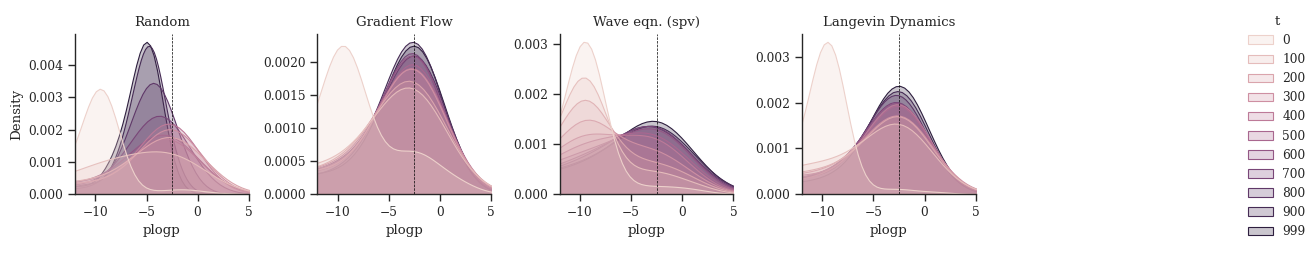

In [17]:
sns.set_theme(
    context='paper',
    style='ticks',
    palette='tab10',
    font='serif',
)

# fig, ax = plt.subplots()

sup_line = df_all.query('t == 999 and name == "Langevin Dynamics"')[prop].mean()

_df = df_all.query(
    '(t % 100 == 0 or t == 999) and name in ["Random", "Gradient Flow", "Wave eqn. (spv)", "Langevin Dynamics"]')
# _df = df_all.query('t % 100 == 0 or t == 999')

# set x-axis limits -10 to 10
g = sns.displot(_df, x=prop, hue='t', kind='kde', fill=True, col='name', height=2.5,
                col_wrap=5, facet_kws={'sharey': False})
g.set_titles('{col_name}')
g.set_xlabels('plogp')
for ax in g.axes.flat:
    ax.set_xlim(-12, 5)
    #plot vertical line at x=0
    ax.axvline(-2.5, color='black', linestyle='--', lw=0.5)
g.savefig(f'ChemFlow/figures/optimization/{prop}_spv_kde.pdf')
g.savefig(f'ChemFlow/figures/optimization/{prop}_spv_kde.png')

Table 1 results for the original methods for plogp and qed.

In [18]:
import pandas as pd
from pathlib import Path

METHOD_CONFIG = {
    "RANDOM": {"method_code": "random", "suffix": "_0.1_relative"},
    "GRADIENT FLOW": {"method_code": "limo", "suffix": "_0.1_relative"},
    "WAVE (SPV)": {"method_code": "wave_sup", "suffix": "_0.1_relative"},
    "WAVE (UNSUP)": {"method_code": "wave_unsup", "suffix": "_0.1_relative"},
    "HJ (SPV)": {"method_code": "hj_sup", "suffix": "_0.1_relative"},
    "HJ (UNSUP)": {"method_code": "hj_unsup", "suffix": "_0.1_relative"},
    "LD": {"method_code": "fp", "suffix": "_0.1_relative"},
}

PROPERTY_CONFIG = {
    "plogP ↑": {"prop_code": "plogp", "maximize": True},
    "QED ↑": {"prop_code": "qed", "maximize": True},
    "ESR1 DOCKING ↓": {"prop_code": "1err", "maximize": False},
    "ACAA1 DOCKING ↓": {"prop_code": "2iik", "maximize": False},
}

ranks = ["1ST", "2ND", "3RD"]
table_data = []
method_names_ordered = ["RANDOM", "GRADIENT FLOW", "WAVE (SPV)", "WAVE (UNSUP)", "HJ (SPV)", "HJ (UNSUP)", "LD"]
property_names_ordered = ["plogP ↑", "QED ↑"]

base_path = Path("ChemFlow/data/interim/uc_optim")

for method_display_name in method_names_ordered:
    config = METHOD_CONFIG[method_display_name]
    method_code = config["method_code"]
    suffix = config["suffix"]
    row_data = {"METHOD": method_display_name}

    for prop_display_name in property_names_ordered:
        prop_info = PROPERTY_CONFIG[prop_display_name]
        prop_code = prop_info["prop_code"]
        maximize = prop_info["maximize"]

        filename = f"{prop_code}_{method_code}{suffix}.csv"
        filepath = base_path / filename
        
        df_prop = pd.read_csv(filepath)
        
        sorted_df = df_prop.sort_values(by=prop_code, ascending=not maximize)
        top_3_values = sorted_df[prop_code].head(3).tolist()
        
        for i, rank in enumerate(ranks):
            if i < len(top_3_values):
                row_data[(prop_display_name, rank)] = top_3_values[i]
            else:
                row_data[(prop_display_name, rank)] = float('nan')
            
    table_data.append(row_data)

df_results = pd.DataFrame(table_data)
df_results = df_results.set_index("METHOD")
df_results.columns = pd.MultiIndex.from_tuples(df_results.columns)

column_formats = {}
for prop_col_name, _ in df_results.columns:
    is_docking = "DOCKING" in prop_col_name
    is_qed = prop_col_name == "QED ↑"
    
    for rank_col_name in ranks:
        if is_docking:
            column_formats[(prop_col_name, rank_col_name)] = '{:.2f}'
        elif is_qed:
            column_formats[(prop_col_name, rank_col_name)] = '{:.3f}'
        else: 
            column_formats[(prop_col_name, rank_col_name)] = '{:.2f}'
            
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
df_results

plogP ↑                         QED ↑                    
                    1ST       2ND       3RD       1ST       2ND       3RD
METHOD                                                                   
RANDOM         3.523312  3.432617  3.365955  0.940105  0.933213  0.931809
GRADIENT FLOW  4.396409  4.274495  3.779748  0.929144  0.928358  0.928266
WAVE (SPV)     4.392646  4.128367  4.051120  0.935251  0.930431  0.928137
WAVE (UNSUP)   3.541071  3.185284  3.090987  0.940782  0.935836  0.934750
HJ (SPV)       4.051120  3.779884  3.695194  0.932741  0.902463  0.894369
HJ (UNSUP)     4.527413  4.267264  3.840987  0.931676  0.928545  0.927687
LD             4.699721  4.025781  3.557703  0.944202  0.933310  0.932964

Table 3 results for the Similarity-constrained Multi-objective (QED-SA) maximization

In [19]:
import pandas as pd
from pathlib import Path
import numpy as np
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem
from tqdm import tqdm

# --- Configuration ---
METHOD_DISPLAY_TO_CODE = {
    "Random": {"code": "random", "suffix": "_0.1_absolute"},
    "Gradient Flow": {"code": "limo", "suffix": "_0.1_absolute"}, # Suffix was relative
    "Wave (SPV)": {"code": "wave_sup", "suffix": "_0.1_absolute"}, # Suffix was relative
    "Wave (UNSUP)": {"code": "wave_unsup", "suffix": "_0.1_absolute"}, # Suffix was relative
    "HJ (SPV)": {"code": "hj_sup", "suffix": "_0.1_absolute"}, # Suffix was relative
    "HJ (UNSUP)": {"code": "hj_unsup", "suffix": "_0.1_absolute"}, # Suffix was relative
    "LD": {"code": "fp", "suffix": "_0.1_absolute"}, # Suffix was relative
}
# Corrected suffixes based on user's file list for qed_sa files.

SIMILARITY_THRESHOLDS = [0.0, 0.2, 0.4, 0.6]
PROPS_TO_OPTIMIZE = ["qed", "sa"] 
N_INITIAL_MOLECULES = 800
N_OPTIMIZATION_STEPS = 1000 # Max value of 't' is steps-1

BASE_OUTPUT_PATH = Path("ChemFlow/data/interim/optimization")
ZINC250K_PROPS_PATH = Path("ChemFlow/data/interim/props/zinc250k.csv")

# --- Helper Functions ---
def get_morgan_fingerprint(mol):
    return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)

def calculate_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    if mol1 is None or mol2 is None:
        return 0.0
    fp1 = get_morgan_fingerprint(mol1)
    fp2 = get_morgan_fingerprint(mol2)
    return DataStructs.TanimotoSimilarity(fp1, fp2)

def scale_property(value, p_min, p_max, target_min=0, target_max=100, maximize=True):
    if p_max == p_min: # Avoid division by zero
        return target_min if (maximize and value <= p_min) or (not maximize and value >= p_min) else target_max

    scaled_val = (value - p_min) / (p_max - p_min)
    if not maximize: # For minimization (like SA), invert normalized score
        scaled_val = 1 - scaled_val
    return scaled_val * (target_max - target_min) + target_min

# --- Load and Prepare Initial Data ---
df_zinc250k = pd.read_csv(ZINC250K_PROPS_PATH)
qed_min_raw, qed_max_raw = df_zinc250k["qed"].min(), df_zinc250k["qed"].max()
sa_min_raw, sa_max_raw = df_zinc250k["sa"].min(), df_zinc250k["sa"].max()

# Select initial molecules based on the logic in optimization_multi.py
df_initial_selection = df_zinc250k[["smiles", "qed", "sa"]].copy()
df_initial_selection["qed_scaled_sel"] = scale_property(df_initial_selection["qed"], qed_min_raw, qed_max_raw, target_max=50, maximize=True)
df_initial_selection["sa_scaled_sel"] = scale_property(df_initial_selection["sa"], sa_min_raw, sa_max_raw, target_max=50, maximize=False) # SA is minimized, so maximize=False gives higher score for lower SA
df_initial_selection["score_sel"] = df_initial_selection["qed_scaled_sel"] + df_initial_selection["sa_scaled_sel"]
df_initial_selection = df_initial_selection.sort_values(by="score_sel", ascending=True).head(N_INITIAL_MOLECULES)

initial_molecules_data = {}
for i, row in df_initial_selection.iterrows():
    initial_molecules_data[len(initial_molecules_data)] = { # Use simple 0-based index matching 'idx'
        "smiles": row["smiles"],
        "qed_raw": row["qed"],
        "sa_raw": row["sa"],
        "qed_scaled_100": scale_property(row["qed"], qed_min_raw, qed_max_raw, maximize=True),
        "sa_scaled_100": scale_property(row["sa"], sa_min_raw, sa_max_raw, maximize=False), # Higher scaled_100 is better
    }

# --- Main Processing Logic ---
results_qed = []
results_sa = []
methods_ordered = list(METHOD_DISPLAY_TO_CODE.keys())

for method_display_name in tqdm(methods_ordered, desc="Processing methods"):
    method_details = METHOD_DISPLAY_TO_CODE[method_display_name]
    method_code = method_details["code"]
    suffix = method_details["suffix"]

    filename = f"{PROPS_TO_OPTIMIZE[0]}_{PROPS_TO_OPTIMIZE[1]}_{method_code}{suffix}.csv"
    filepath = BASE_OUTPUT_PATH / filename

    row_data_qed = {"Method": method_display_name}
    row_data_sa = {"Method": method_display_name}

    if not filepath.exists():
        print(f"File not found: {filepath}, skipping {method_display_name}")
        for sim_thresh in SIMILARITY_THRESHOLDS:
            col_name = f"δ = {sim_thresh:.1f}"
            row_data_qed[col_name] = "N/A"
            row_data_sa[col_name] = "N/A"
        results_qed.append(row_data_qed)
        results_sa.append(row_data_sa)
        continue

    df_method_output = pd.read_csv(filepath)

    processed_steps = []
    for _, gen_row in df_method_output.iterrows():
        idx = gen_row["idx"]
        if idx not in initial_molecules_data:
            continue 
            
        initial_data = initial_molecules_data[idx]
        sim = calculate_similarity(gen_row["smiles"], initial_data["smiles"])
        
        final_qed_scaled_100 = scale_property(gen_row["qed"], qed_min_raw, qed_max_raw, maximize=True)
        final_sa_scaled_100 = scale_property(gen_row["sa"], sa_min_raw, sa_max_raw, maximize=False) # Higher is better

        delta_qed = final_qed_scaled_100 - initial_data["qed_scaled_100"]
        delta_sa = final_sa_scaled_100 - initial_data["sa_scaled_100"]
        
        processed_steps.append({
            "idx": idx, "t": gen_row["t"], "sim": sim,
            "delta_qed": delta_qed, "delta_sa": delta_sa
        })
    
    df_processed_method = pd.DataFrame(processed_steps)

    for sim_thresh in SIMILARITY_THRESHOLDS:
        col_name = f"δ = {sim_thresh:.1f}"
        df_sim_filtered = df_processed_method[df_processed_method["sim"] >= sim_thresh]

        # QED
        if not df_sim_filtered.empty:
            best_delta_qed_per_idx = df_sim_filtered.groupby("idx")["delta_qed"].max()
        else:
            best_delta_qed_per_idx = pd.Series(dtype=float)
        
        # Ensure all N_INITIAL_MOLECULES are represented, defaulting to -inf if no valid/better step found
        all_idx_best_delta_qed = pd.Series(-np.inf, index=range(N_INITIAL_MOLECULES), dtype=float)
        all_idx_best_delta_qed.update(best_delta_qed_per_idx)

        successful_qed = all_idx_best_delta_qed[all_idx_best_delta_qed > 0]
        mean_qed = successful_qed.mean() if not successful_qed.empty else 0.0
        std_qed = successful_qed.std() if not successful_qed.empty else 0.0
        succ_rate_qed = len(successful_qed) / N_INITIAL_MOLECULES if N_INITIAL_MOLECULES > 0 else 0.0
        row_data_qed[col_name] = f"{mean_qed:.1f} ± {std_qed:.1f} ({succ_rate_qed*100:.1f})"

        # SA
        if not df_sim_filtered.empty:
            best_delta_sa_per_idx = df_sim_filtered.groupby("idx")["delta_sa"].max()
        else:
            best_delta_sa_per_idx = pd.Series(dtype=float)

        all_idx_best_delta_sa = pd.Series(-np.inf, index=range(N_INITIAL_MOLECULES), dtype=float)
        all_idx_best_delta_sa.update(best_delta_sa_per_idx)

        successful_sa = all_idx_best_delta_sa[all_idx_best_delta_sa > 0]
        mean_sa = successful_sa.mean() if not successful_sa.empty else 0.0
        std_sa = successful_sa.std() if not successful_sa.empty else 0.0
        succ_rate_sa = len(successful_sa) / N_INITIAL_MOLECULES if N_INITIAL_MOLECULES > 0 else 0.0
        row_data_sa[col_name] = f"{mean_sa:.2f} ± {std_sa:.2f} ({succ_rate_sa*100:.1f})"
        
    results_qed.append(row_data_qed)
    results_sa.append(row_data_sa)



Processing methods:   0%|          | 0/7 [00:00<?, ?it/s][11:00:17] Conflicting single bond directions around double bond at index 10.
[11:00:17]   BondStereo set to STEREONONE and single bond directions set to NONE.
[11:00:17] Conflicting single bond directions around double bond at index 10.
[11:00:17]   BondStereo set to STEREONONE and single bond directions set to NONE.
[11:00:17] Conflicting single bond directions around double bond at index 10.
[11:00:17]   BondStereo set to STEREONONE and single bond directions set to NONE.
[11:00:17] Conflicting single bond directions around double bond at index 10.
[11:00:17]   BondStereo set to STEREONONE and single bond directions set to NONE.
[11:00:18] Conflicting single bond directions around double bond at index 10.
[11:00:18]   BondStereo set to STEREONONE and single bond directions set to NONE.
[11:00:18] Conflicting single bond directions around double bond at index 10.
[11:00:18]   BondStereo set to STEREONONE and single bond directi

In [20]:
# --- Display Results ---
df_table_qed = pd.DataFrame(results_qed).set_index("Method")
df_table_sa = pd.DataFrame(results_sa).set_index("Method")

# Optional: Display settings
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

# Title and display
from IPython.display import display, Markdown

display(Markdown("### Multi-objective (QED-SA) Maximization - QED Improvement"))
display(df_table_qed)

display(Markdown("### Multi-objective (QED-SA) Maximization - SA Improvement (higher scaled score is better)"))
display(df_table_sa)

### Multi-objective (QED-SA) Maximization - QED Improvement

,δ = 0.0,δ = 0.2,δ = 0.4,δ = 0.6
Method,,,,
Random,34.7 ± 16.4 (98.6),19.0 ± 14.6 (76.9),13.0 ± 11.1 (52.2),12.2 ± 12.1 (23.9)
Gradient Flow,36.4 ± 16.4 (99.4),21.7 ± 15.5 (79.1),14.9 ± 13.0 (46.1),13.6 ± 12.8 (17.6)
Wave (SPV),35.1 ± 16.7 (97.9),12.3 ± 2.6 (0.2),0.0 ± 0.0 (0.0),0.0 ± 0.0 (0.0)
Wave (UNSUP),35.2 ± 17.2 (94.5),20.7 ± 14.5 (3.9),0.0 ± 0.0 (0.0),0.0 ± 0.0 (0.0)
HJ (SPV),35.0 ± 15.7 (98.6),20.0 ± 15.3 (76.4),11.7 ± 10.8 (48.4),8.5 ± 7.6 (25.1)
HJ (UNSUP),37.6 ± 17.4 (96.5),23.7 ± 18.6 (4.4),0.0 ± 0.0 (0.0),0.0 ± 0.0 (0.0)
LD,48.8 ± 14.6 (100.0),26.1 ± 15.4 (92.8),16.4 ± 12.9 (71.6),12.7 ± 11.9 (38.8)


### Multi-objective (QED-SA) Maximization - SA Improvement (higher scaled score is better)

,δ = 0.0,δ = 0.2,δ = 0.4,δ = 0.6
Method,,,,
Random,31.11 ± 16.66 (96.0),13.27 ± 10.97 (64.0),9.26 ± 8.80 (37.6),5.37 ± 5.70 (15.8)
Gradient Flow,39.07 ± 17.99 (97.4),15.68 ± 12.54 (67.9),9.12 ± 8.40 (32.5),6.00 ± 6.82 (12.8)
Wave (SPV),32.66 ± 20.05 (95.5),7.82 ± 4.59 (0.2),0.00 ± 0.00 (0.0),0.00 ± 0.00 (0.0)
Wave (UNSUP),35.28 ± 17.09 (97.8),18.77 ± 16.98 (3.6),0.79 ± nan (0.1),0.00 ± 0.00 (0.0)
HJ (SPV),34.38 ± 18.76 (98.4),12.82 ± 11.07 (64.9),8.11 ± 8.73 (34.9),6.30 ± 7.46 (14.6)
HJ (UNSUP),38.69 ± 17.70 (97.5),22.13 ± 13.48 (5.9),24.65 ± nan (0.1),0.00 ± 0.00 (0.0)
LD,51.73 ± 18.43 (100.0),19.74 ± 13.61 (86.9),11.26 ± 9.59 (57.8),7.36 ± 7.24 (26.8)


Table 4: Success Rate of traversing latent molecule space to manipulate to manipulate a variety of properties.

In [23]:
import pandas as pd
from pathlib import Path
import numpy as np
from IPython.display import display, Markdown

METHOD_MAP = {
    "RANDOM-1D": {"file_prefix": "random_1d", "spv": False},
    "RANDOM": {"file_prefix": "random", "spv": False},
 #   "CHEMSPACE": {"file_prefix": "chemspace", "spv": False},
    "WAVE (UNSUP)": {"file_prefix": "unsup_pde", "spv": False},
    "WAVE (SPV)": {"file_prefix": "sup_pde", "spv": True},
    "HJ (UNSUP)": {"file_prefix": "unsup_hj", "spv": False},
    "HJ (SPV)": {"file_prefix": "sup_hj", "spv": True},
    "GF (SPV)": {"file_prefix": "limo", "spv": True},
    "LD (SPV)": {"file_prefix": "fp", "spv": True},
}

PROPERTIES_MAP = {
    "PLOGP (↑)": "plogp",
    "QED (↑)": "qed",
    "SA (↓)": "sa",
    "DRD2 (↑)": "drd2",
    "JNK3 (↑)": "jnk3",
    "GSK3B (↑)": "gsk3b",
}

N_MOLECULES_SUCCESS_RATE = 1000
BASE_SUCCESS_RATE_PATH = Path(f"ChemFlow/experiments/success_rate")

table_rows = []
methods_in_table_order = list(METHOD_MAP.keys())
properties_in_table_order = list(PROPERTIES_MAP.keys())

for method_display_name in methods_in_table_order:
    method_info = METHOD_MAP[method_display_name]
    file_prefix_from_map = method_info["file_prefix"]
    
    row_data = {"METHOD": method_display_name}
    all_prop_strict_rates = []
    all_prop_relaxed_rates = []

    for prop_display_name in properties_in_table_order:
        prop_code = PROPERTIES_MAP[prop_display_name]
        data_file = BASE_SUCCESS_RATE_PATH / f"{prop_code}_{N_MOLECULES_SUCCESS_RATE}.txt"
        strict_rate = 0.0
        relaxed_rate = 0.0

        if data_file.exists():
            with open(data_file, 'r') as f:
                for line in f:
                    parts = [p.strip() for p in line.split('|')]
                    if len(parts) > 1 and parts[0] == file_prefix_from_map:
                        if len(parts) >= 6: 
                            try:
                                strict_val_str = parts[4].split(' ')[-1] if ' ' in parts[4] else parts[4]
                                relaxed_val_str = parts[5].split(' ')[-1] if ' ' in parts[5] else parts[5]
                                strict_rate = float(strict_val_str) * 100
                                relaxed_rate = float(relaxed_val_str) * 100
                                break 
                            except (ValueError, IndexError):
                                pass 
                        
        row_data[prop_display_name] = f"{strict_rate:.2f} / {relaxed_rate:.2f}"
        all_prop_strict_rates.append(strict_rate)
        all_prop_relaxed_rates.append(relaxed_rate)

    avg_strict = np.mean(all_prop_strict_rates) if all_prop_strict_rates else 0.0
    avg_relaxed = np.mean(all_prop_relaxed_rates) if all_prop_relaxed_rates else 0.0
    row_data["AVERAGE_STRICT_VAL"] = avg_strict
    row_data["AVERAGE_RELAXED_VAL"] = avg_relaxed
    row_data["AVERAGE_DISPLAY"] = f"{avg_strict:.2f} / {avg_relaxed:.2f}"
    table_rows.append(row_data)

df_results = pd.DataFrame(table_rows)
df_results = df_results.set_index("METHOD") 

df_results['RANK_STRICT'] = df_results['AVERAGE_STRICT_VAL'].rank(method='min', ascending=False)
df_results['RANK_RELAXED'] = df_results['AVERAGE_RELAXED_VAL'].rank(method='min', ascending=False)
df_results['AVERAGE_OF_RANKS'] = (df_results['RANK_STRICT'] + df_results['RANK_RELAXED']) / 2
df_results['RANKING'] = df_results['AVERAGE_OF_RANKS'].rank(method='min').astype(int)

cols_display = ['RANKING', 'AVERAGE_DISPLAY'] + properties_in_table_order
df_final_display = df_results.reindex(methods_in_table_order)[cols_display]
df_final_display.rename(columns={'AVERAGE_DISPLAY': 'AVERAGE'}, inplace=True)
df_final_display.index.name = None

styled_table = df_final_display.style.set_caption("Table 4: Success Rate of Traversing Latent Molecule Space").set_table_styles(
    [{'selector': 'caption',
      'props': [('color', 'black'),
                ('font-size', '16px'),
                ('font-weight', 'bold'),
                ('text-align', 'center')]}
    ]
).format(precision=2)

display(Markdown("### Table 4: Success Rate of Traversing Latent Molecule Space"))
display(styled_table)

### Table 4: Success Rate of Traversing Latent Molecule Space

,RANKING,AVERAGE,PLOGP (↑),QED (↑),SA (↓),DRD2 (↑),JNK3 (↑),GSK3B (↑)
RANDOM-1D,8,0.00 / 0.00,0.00 / 0.00,0.00 / 0.00,0.00 / 0.00,0.00 / 0.00,0.00 / 0.00,0.00 / 0.00
RANDOM,4,0.47 / 45.60,0.60 / 42.00,0.30 / 4.40,0.20 / 8.10,0.10 / 90.40,0.70 / 82.80,0.90 / 45.90
WAVE (UNSUP),1,3.58 / 48.22,1.60 / 51.60,0.50 / 2.30,2.90 / 13.80,3.20 / 83.50,6.00 / 79.90,7.30 / 58.20
WAVE (SPV),5,2.47 / 9.73,4.30 / 21.20,6.50 / 16.60,3.10 / 16.90,0.70 / 3.20,0.10 / 0.20,0.10 / 0.30
HJ (UNSUP),6,0.97 / 18.63,0.50 / 33.80,0.60 / 2.80,1.00 / 12.40,1.10 / 11.80,1.80 / 11.50,0.80 / 39.50
HJ (SPV),7,2.40 / 9.10,4.60 / 19.80,5.90 / 15.00,2.60 / 13.40,1.30 / 6.40,0.00 / 0.00,0.00 / 0.00
GF (SPV),1,7.07 / 27.82,7.00 / 29.80,6.50 / 16.20,5.70 / 20.70,5.80 / 33.70,10.10 / 36.50,7.30 / 30.00
LD (SPV),3,6.47 / 25.52,5.80 / 27.00,5.50 / 14.20,6.60 / 19.90,4.80 / 31.60,9.20 / 32.40,6.90 / 28.00


Up to here we have dealt with the inital implementation. Moving now to extensions.

Perform the random walkd and the neyghboring search for unsuperivsed scenario using MolGenTransformers for qed.

In [ ]:
!python -m ChemFlow.extend.MolgenRandomWalkSimilarityConstrained qed

Same for plogp

In [ ]:
!python -m ChemFlow.extend.MolgenRandomWalkSimilarityConstrained plogp

In [24]:
import pandas as pd
import numpy as np
from pathlib import Path

def get_top_n_property_values(df_for_selection: pd.DataFrame, property_col: str, n_top: int, ascending_order: bool):
    if df_for_selection.empty or property_col not in df_for_selection.columns:
        return [np.nan] * n_top
    
    sorted_df = df_for_selection.sort_values(by=property_col, ascending=ascending_order, na_position='last')
    top_values = sorted_df[property_col].head(n_top).tolist()
    
    if len(top_values) < n_top:
        top_values.extend([np.nan] * (n_top - len(top_values)))
    return top_values

def analyze_method_results(
    plogp_csv_path_str: str,
    qed_csv_path_str: str,
    blacklist_smiles: set
):
    plogp_path = Path(plogp_csv_path_str)
    qed_path   = Path(qed_csv_path_str)
    
    default_results = {
        ('plogP ↑', '1ST'): np.nan, ('plogP ↑', '2ND'): np.nan, ('plogP ↑', '3RD'): np.nan,
        ('QED ↑',  '1ST'): np.nan, ('QED ↑',  '2ND'): np.nan, ('QED ↑',  '3RD'): np.nan,
    }

    if not plogp_path.is_file() or not qed_path.is_file():
        return default_results

    df_plogp = pd.read_csv(plogp_path).dropna(subset=['smiles','plogp'])
    df_qed   = pd.read_csv(qed_path)  .dropna(subset=['smiles','qed'])
    df_plogp['smiles'] = df_plogp['smiles'].astype(str)
    df_qed['smiles']   = df_qed['smiles'].astype(str)

    df_plogp = df_plogp[~df_plogp['smiles'].isin(blacklist_smiles)].drop_duplicates('smiles', keep='first')
    df_qed   = df_qed[~df_qed['smiles'].isin(blacklist_smiles)].drop_duplicates('smiles', keep='first')
    if df_plogp.empty or df_qed.empty:
        return default_results

    top_plogp = get_top_n_property_values(df_plogp, 'plogp', 3, False)
    top_qed   = get_top_n_property_values(df_qed,   'qed',   3, False)
    
    return {
        ('plogP ↑', '1ST'): top_plogp[0], ('plogP ↑', '2ND'): top_plogp[1], ('plogP ↑', '3RD'): top_plogp[2],
        ('QED ↑',  '1ST'): top_qed[0],  ('QED ↑',  '2ND'): top_qed[1],  ('QED ↑',  '3RD'): top_qed[2],
    }

blacklist_file_path = "ChemFlow/data/interim/props/zinc250k.csv"

input_csv_for_random_walk = "ChemFlow/extend/optimization_results_molgen_truncated_100steps/plogp_random_walk_s2.0_t100_n800.csv"
input_csv_for_neighbor_search = "ChemFlow/extend/optimization_results_molgen_truncated_100steps/plogp_neighboring_search_nv10_r20.0_res0.05_n800.csv"

loaded_blacklist_smiles = set()
blacklist_path_obj = Path(blacklist_file_path)
if blacklist_path_obj.is_file():
    df_blacklist_data = pd.read_csv(blacklist_path_obj)
    if 'smiles' in df_blacklist_data.columns:
        loaded_blacklist_smiles = set(df_blacklist_data['smiles'].astype(str).dropna())

analysis_rows = []

method_configurations = [
    {
      "name": "random_walk_transformer",
      "plogp_path": input_csv_for_random_walk,
      "qed_path":   input_csv_for_random_walk.replace("plogp", "qed")
    },
    {
      "name": "neighbor_search_transformer",
      "plogp_path": input_csv_for_neighbor_search,
      "qed_path":   input_csv_for_neighbor_search.replace("plogp", "qed")
    }
]

for config in method_configurations:
    current_method_properties = analyze_method_results(
        config["plogp_path"],
        config["qed_path"],
        loaded_blacklist_smiles
    )
    current_method_row = {'METHOD': config["name"], **current_method_properties}
    analysis_rows.append(current_method_row)

output_dataframe = pd.DataFrame(analysis_rows)

if not output_dataframe.empty:
    output_dataframe = output_dataframe.set_index('METHOD')
    
    column_multi_index = pd.MultiIndex.from_tuples([
        ('plogP ↑', '1ST'), ('plogP ↑', '2ND'), ('plogP ↑', '3RD'),
        ('QED ↑',  '1ST'), ('QED ↑',  '2ND'), ('QED ↑',  '3RD')
    ])
    output_dataframe = output_dataframe.reindex(columns=column_multi_index)
else:
    column_multi_index = pd.MultiIndex.from_product(
        [['plogP ↑', 'QED ↑'], ['1ST', '2ND', '3RD']],
    )
    output_dataframe = pd.DataFrame(columns=column_multi_index, index=pd.Index([], name='METHOD'))
    
output_dataframe


plogP ↑                         QED ↑                    
                                  1ST       2ND       3RD       1ST       2ND       3RD
METHOD                                                                                 
random_walk_transformer      4.519903  4.397062  4.377148  0.948442  0.948331  0.948258
neighbor_search_transformer  5.345118  5.323837  5.140254  0.948442  0.948442  0.948434

These are some approaches to train a neural ode that partially worked

In [ ]:
!python -m ChemFlow.experiments.train_neural_ode --prop_name plogp --data_name zmc --is_supervised --epochs 40 --output_dir_base checkpoints/neural_ode --model_params.latent_dim 1024 --model_params.learning_rate 1e-4 --model_params.integration_time_step 0.2 --model_params.num_loss_integration_steps 5 --model_params.flow_reg_lambda 0.01 --data_params.batch_size 128

In [ ]:
!python -m ChemFlow.experiments.train_neural_ode     --prop_name qed     --data_name zmc     --is_supervised     --epochs 40     --output_dir_base checkpoints/neural_ode     --model_params.latent_dim 1024     --model_params.learning_rate 1e-4     --model_params.integration_time_step 0.2     --model_params.num_loss_integration_steps 5     --model_params.flow_reg_lambda 0.01     --data_params.batch_size 128

In [ ]:
!python -m ChemFlow.experiments.optimization.uc_optim --prop plogp --method neural_ode --data_name zmc --n 100000 --steps 10 --batch_size 1000 --step_size 0.1 --seed 42

In [ ]:
!python -m ChemFlow.experiments.optimization.uc_optim --prop qed --method neural_ode --data_name zmc --n 100000 --steps 10 --batch_size 1000 --step_size 0.1 --seed 42

Present the results for qed and plogp

In [25]:
import pandas as pd
from pathlib import Path
import numpy as np

METHOD_CONFIG = {
    "RANDOM": {"method_code": "random", "suffix": "_0.1_relative"},
    "GRADIENT FLOW": {"method_code": "limo", "suffix": "_0.1_relative"},
    "WAVE (SPV)": {"method_code": "wave_sup", "suffix": "_0.1_relative"},
    "WAVE (UNSUP)": {"method_code": "wave_unsup", "suffix": "_0.1_relative"},
    "HJ (SPV)": {"method_code": "hj_sup", "suffix": "_0.1_relative"},
    "HJ (UNSUP)": {"method_code": "hj_unsup", "suffix": "_0.1_relative"},
    "LD": {"method_code": "fp", "suffix": "_0.1_relative"},
    "ODE": {"method_code": "neural_ode", "suffix": "_0.1_relative"},
    "LATENT STEPPER": {"method_code": "latent_stepper", "suffix": "_0.1_relative"},
    "hybrid_ld_hj": {"method_code": "hybrid_sup_unsup", "suffix": "_0.1_relative"},
}

PROPERTY_CONFIG = {
    "plogP ↑": {"prop_code": "plogp", "maximize": True},
    "QED ↑": {"prop_code": "qed", "maximize": True},
    "ESR1 DOCKING ↓": {"prop_code": "1err", "maximize": False},
    "ACAA1 DOCKING ↓": {"prop_code": "2iik", "maximize": False},
}

ranks = ["1ST", "2ND", "3RD"]
table_data = []
method_names_ordered = [
    "RANDOM", "GRADIENT FLOW", "WAVE (SPV)", "WAVE (UNSUP)",
    "HJ (SPV)", "HJ (UNSUP)", "LD", "ODE",
    "LATENT STEPPER", "hybrid_ld_hj"
]
property_names_ordered = ["plogP ↑", "QED ↑"]

base_path = Path("ChemFlow/data/interim/uc_optim")

for method_display_name in method_names_ordered:
    config = METHOD_CONFIG[method_display_name]
    method_code = config["method_code"]
    suffix = config["suffix"]
    row_data = {"METHOD": method_display_name}

    for prop_display_name in property_names_ordered:
        prop_info = PROPERTY_CONFIG[prop_display_name]
        prop_code = prop_info["prop_code"]
        maximize = prop_info["maximize"]

        filename = f"{prop_code}_{method_code}{suffix}.csv"
        filepath = base_path / filename

        # try to read the file, otherwise fill with NaNs
        try:
            df_prop = pd.read_csv(filepath)
            sorted_df = df_prop.sort_values(by=prop_code, ascending=not maximize)
            top_3_values = sorted_df[prop_code].head(3).tolist()
        except FileNotFoundError:
            top_3_values = [np.nan, np.nan, np.nan]

        for i, rank in enumerate(ranks):
            row_data[(prop_display_name, rank)] = top_3_values[i]

    table_data.append(row_data)
    # Add analysis_rows results to table_data
for method_name, row in output_dataframe.iterrows():
    method_row = {"METHOD": method_name}
    
    # Add all property-rank pairs from the row to method_row
    for (prop_name, rank), value in row.items():
        method_row[(prop_name, rank)] = value
    
    table_data.append(method_row)
df_results = pd.DataFrame(table_data)
#concate output_dataframe and table_data to df_results
#df1_for_concat = output_dataframe.reset_index()
#df2_for_concat = pd.DataFrame(table_data)
#df_results = pd.concat([df1_for_concat, df2_for_concat], axis=0, ignore_index=True)
df_results = df_results.set_index("METHOD")
df_results.columns = pd.MultiIndex.from_tuples(df_results.columns)

# formatting strings per column
column_formats = {}
for prop_col_name, _ in df_results.columns:
    is_docking = "DOCKING" in prop_col_name
    is_qed = prop_col_name == "QED ↑"
    for rank_col_name in ranks:
        if is_docking:
            column_formats[(prop_col_name, rank_col_name)] = "{:.2f}"
        elif is_qed:
            column_formats[(prop_col_name, rank_col_name)] = "{:.3f}"
        else:
            column_formats[(prop_col_name, rank_col_name)] = "{:.2f}"

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

# --- NEW: use Styler to format and bold the best values ---
styler = (
    df_results
    .style
    .format(column_formats)
    .highlight_max(axis=0, props="font-weight:bold")
)

styler

its time to measure the 'real' properties of our molecules

In [26]:
import pandas as pd
import os
from rdkit import Chem

# --- The Normalization Function ---
# This function takes a SMILES string, tries to read it,
# removes explicit hydrogens, and returns a clean, canonical SMILES string.
# If it fails at any point, it returns None.
def normalize_and_validate_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        Chem.RemoveHs(mol)
        return Chem.MolToSmiles(mol, isomericSmiles=True)
    except:
        return None

# --- Main Data Loading and Processing Loop ---
file_paths = [
    "ChemFlow/data/interim/uc_optim/plogp_random_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/qed_random_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/plogp_limo_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/qed_limo_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/plogp_wave_sup_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/qed_wave_sup_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/plogp_wave_unsup_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/qed_wave_unsup_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/plogp_hj_sup_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/qed_hj_sup_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/plogp_hj_unsup_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/qed_hj_unsup_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/plogp_fp_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/qed_fp_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/plogp_neural_ode_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/qed_neural_ode_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/plogp_latent_stepper_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/plogp_hybrid_sup_unsup_0.1_relative.csv",
    "ChemFlow/extend/optimization_results_molgen_truncated_100steps/plogp_random_walk_s2.0_t100_n800.csv",
    "ChemFlow/extend/optimization_results_molgen_truncated_100steps/qed_random_walk_s2.0_t100_n800.csv",
    "ChemFlow/extend/optimization_results_molgen_truncated_100steps/plogp_neighboring_search_nv10_r20.0_res0.05_n800.csv",
    "ChemFlow/extend/optimization_results_molgen_truncated_100steps/qed_neighboring_search_nv10_r20.0_res0.05_n800.csv"
]

top_molecules_list = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    df['smiles'] = df['smiles'].str.strip()
    filename = os.path.basename(file_path)
    if 'qed' in filename: score_column = 'qed'
    else: score_column = 'plogp'
    optimization_method = filename.replace('.csv', '').replace('_0.1_relative', '')
    top_3_df = df.sort_values(by=score_column, ascending=False).head(3).copy()
    top_3_df['optimization_method'] = optimization_method
    top_3_df['score_type'] = score_column
    top_3_df['original_score'] = top_3_df[score_column]
    top_molecules_list.append(top_3_df)

master_df = pd.concat(top_molecules_list, ignore_index=True)

# --- Apply the new normalization and validation step ---
master_df['clean_smiles'] = master_df['smiles'].apply(normalize_and_validate_smiles)

# Create the final, clean DataFrame by dropping any rows where normalization failed
valid_master_df = master_df.dropna(subset=['clean_smiles']).copy()

# Create the RDKit molecule objects from the CLEANED smiles
valid_master_df['rdkit_mol'] = valid_master_df['clean_smiles'].apply(Chem.MolFromSmiles)

print(f"Total molecules loaded: {len(master_df)}")
print(f"Total VALID and NORMALIZED molecules: {len(valid_master_df)}")

Total molecules loaded: 66
Total VALID and NORMALIZED molecules: 66


Visualize the molecules

--- Generating Final Grid Image in Chunks of 12 ---


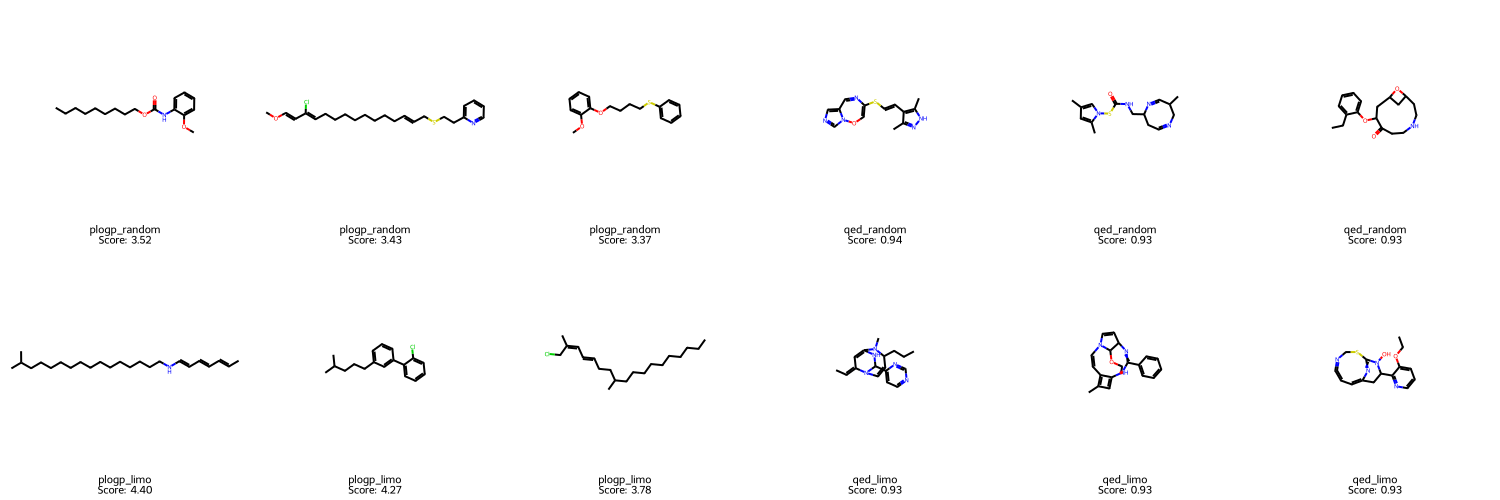

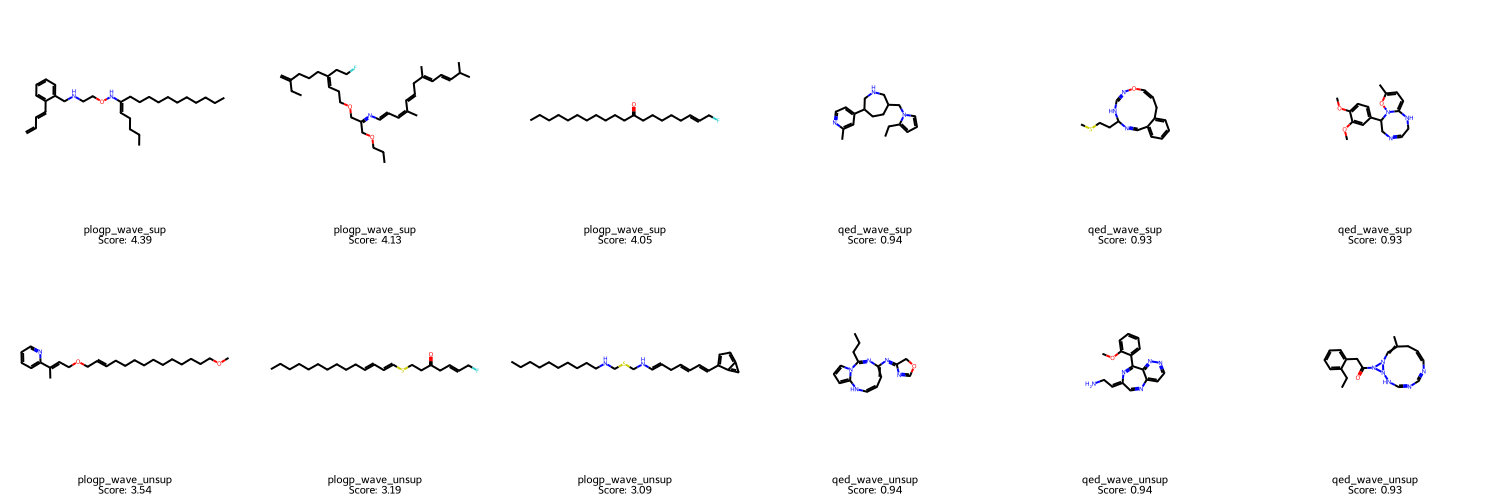

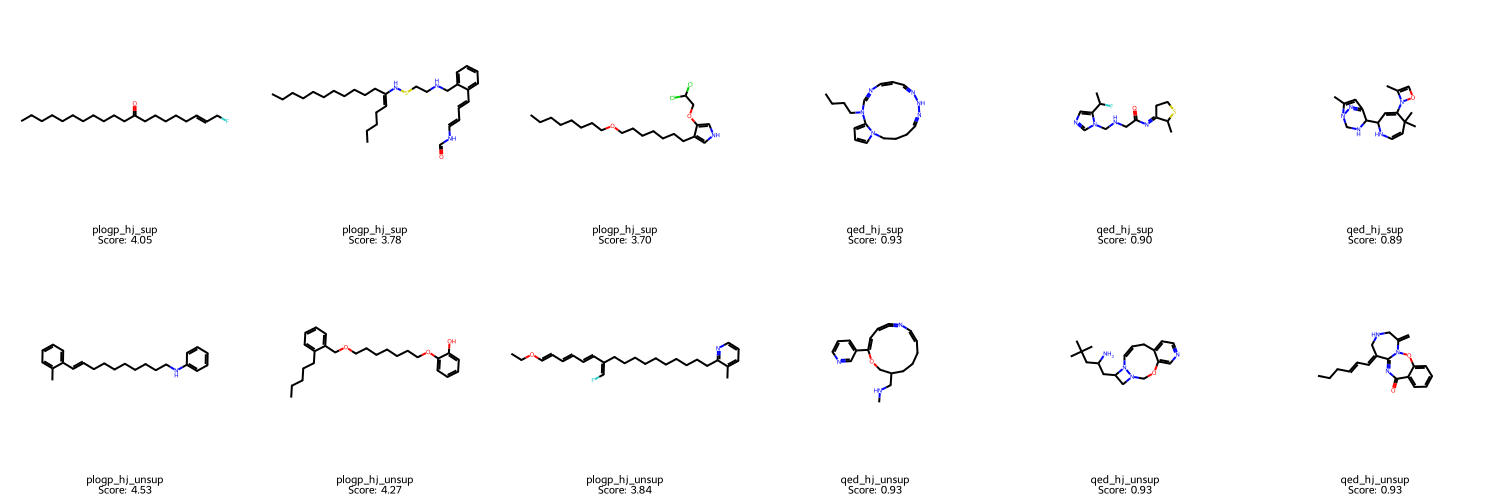

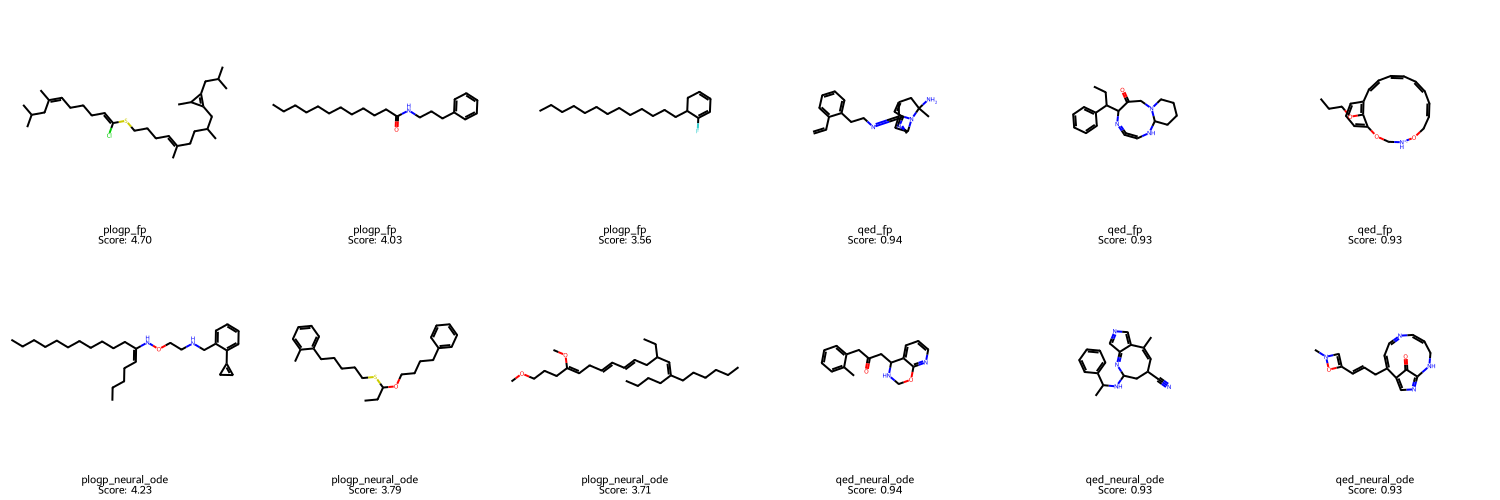

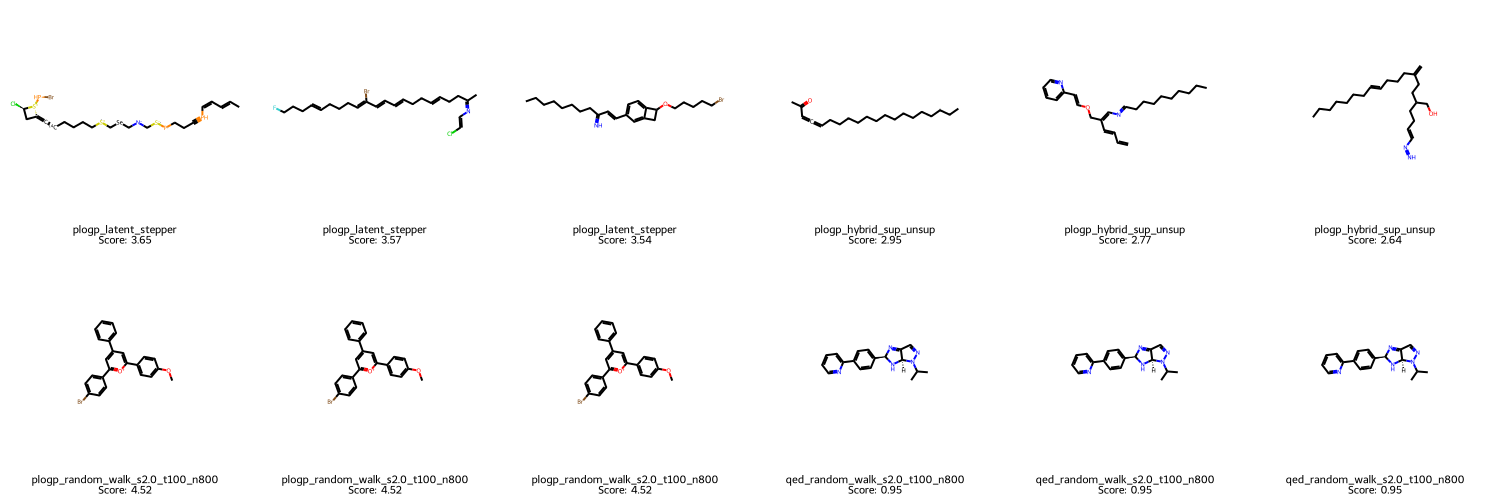

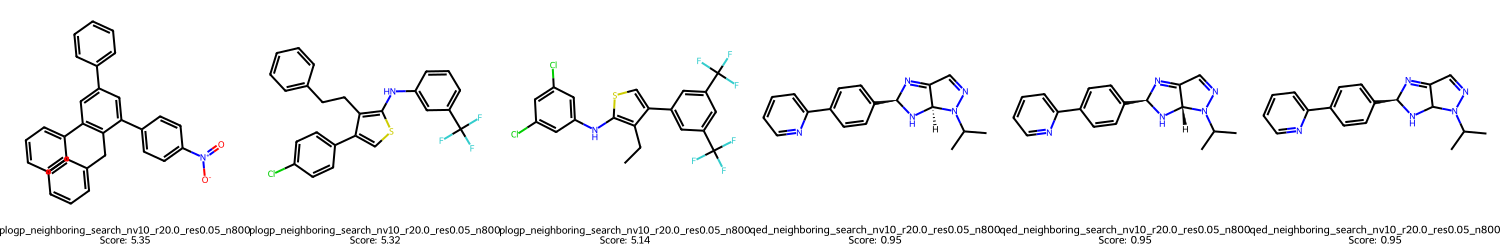


--- Full Grid Generation Complete ---


In [ ]:
from rdkit.Chem import Draw
from IPython.display import display


mols = list(valid_master_df['rdkit_mol'])
legends = [f"{row['optimization_method']}\nScore: {row['original_score']:.2f}" for index, row in valid_master_df.iterrows()]

chunk_size = 12
print(f"--- Generating Final Grid Image in Chunks of {chunk_size} ---")

for i in range(0, len(mols), chunk_size):
    start_index = i
    end_index = i + chunk_size
    
    mol_chunk = mols[start_index:end_index]
    legend_chunk = legends[start_index:end_index]
    
    try:
        img = Draw.MolsToGridImage(mol_chunk, molsPerRow=6, subImgSize=(250, 250), legends=legend_chunk)
        
        display(img)
        
    except Exception as e:
        print(f"\n--- SKIPPING a problematic chunk (indices {start_index}-{end_index-1}) due to an error ---")
        print(f"Error: {e}")
        continue

print("\n--- Full Grid Generation Complete ---")

In [28]:
from rdkit.Chem import Descriptors

mol_objects = [Chem.MolFromSmiles(s) for s in master_df['smiles']]

master_df['MolWt'] = [Descriptors.MolWt(m) for m in mol_objects]
master_df['LogP'] = [Descriptors.MolLogP(m) for m in mol_objects]
master_df['NumHDonors'] = [Descriptors.NumHDonors(m) for m in mol_objects]
master_df['NumHAcceptors'] = [Descriptors.NumHAcceptors(m) for m in mol_objects]
master_df['NumRotatableBonds'] = [Descriptors.NumRotatableBonds(m) for m in mol_objects]
# set display to display all rows 
pd.set_option('display.max_rows', None)
display(master_df[['optimization_method', 'original_score', 'MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors']].round(2))

,optimization_method,original_score,MolWt,LogP,NumHDonors,NumHAcceptors
0,plogp_random,3.52,293.41,4.99,1,3
1,plogp_random,3.43,408.05,7.32,0,3
2,plogp_random,3.37,288.41,4.65,0,3
3,qed_random,0.94,287.35,2.29,1,6
4,qed_random,0.93,306.44,2.86,1,5
5,qed_random,0.93,303.40,2.50,1,4
6,plogp_limo,4.40,347.63,7.95,1,1
7,plogp_limo,4.27,272.82,5.99,0,0
8,plogp_limo,3.78,312.97,7.67,0,0
9,qed_limo,0.93,297.41,2.75,1,5


In [29]:
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

def count_lipinski_violations(mol):
    violations = 0
    if Descriptors.MolWt(mol) > 500:
        violations += 1
    if Descriptors.MolLogP(mol) > 5:
        violations += 1
    if Descriptors.NumHDonors(mol) > 5:
        violations += 1
    if Descriptors.NumHAcceptors(mol) > 10:
        violations += 1
    return violations

def has_pains(mol):
    return catalog.HasMatch(mol)

master_df['Lipinski_Violations'] = [count_lipinski_violations(m) for m in mol_objects]
master_df['Is_PAINS'] = [has_pains(m) for m in mol_objects]
master_df['TPSA'] = [Descriptors.TPSA(m) for m in mol_objects]

pd.set_option('display.max_rows', len(master_df))
display(master_df[['optimization_method', 'original_score', 'Lipinski_Violations', 'Is_PAINS', 'TPSA']].round(2))

,optimization_method,original_score,Lipinski_Violations,Is_PAINS,TPSA
0,plogp_random,3.52,0,False,47.56
1,plogp_random,3.43,1,False,22.12
2,plogp_random,3.37,0,False,18.46
3,qed_random,0.94,0,False,68.09
4,qed_random,0.93,0,False,58.75
5,qed_random,0.93,0,False,47.56
6,plogp_limo,4.40,1,False,12.03
7,plogp_limo,4.27,1,False,0.00
8,plogp_limo,3.78,1,False,0.00
9,qed_limo,0.93,0,False,44.29


3D Ligan filed for docking preperation of the molecules

In [30]:
master_df = pd.read_csv("master_df.csv")

In [31]:
ligand_dir = "ligand_files_3d"
os.makedirs(ligand_dir, exist_ok=True)

for index, row in master_df.iterrows():
    mol = Chem.MolFromSmiles(row['smiles'])
    mol_h = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol_h, randomSeed=42)
    try:
        AllChem.MMFFOptimizeMolecule(mol_h)
    except:
        continue
    ligand_filename = os.path.join(ligand_dir, f"ligand_{index}.sdf")
    writer = Chem.SDWriter(ligand_filename)
    writer.write(mol_h)
    writer.close()

print(f"Generated 3D structures for all {len(master_df)} ligands in '{ligand_dir}'")

[11:53:24] UFFTYPER: Warning: hybridization set to SP3 for atom 5


Generated 3D structures for all 66 ligands in 'ligand_files_3d'


In [32]:
import py3Dmol
import os
import re

# Define the optimization methods from the last 4 files
last_four_methods = [
    "plogp_random_walk_s2.0_t100_n800",
    "qed_random_walk_s2.0_t100_n800",
    "plogp_neighboring_search_nv10_r20.0_res0.05_n800",
    "qed_neighboring_search_nv10_r20.0_res0.05_n800"
]

# Filter the master DataFrame to get only the molecules from these methods
subset_df = master_df[master_df['optimization_method'].isin(last_four_methods)].reset_index()

# Setup the grid for 12 molecules (3 rows, 4 columns)
rows = 3
cols = 4
view = py3Dmol.view(width=1200, height=600, viewergrid=(rows, cols))

for i, row_data in subset_df.iterrows():
    # The original index is what we used to name the file
    original_index = row_data['index']
    sdf_file = os.path.join(ligand_dir, f"ligand_{original_index}.sdf")
    
    with open(sdf_file, 'r') as f:
        sdf_content = f.read()
    
    # Get metadata for the label
    opt_method = row_data['optimization_method']
    score = row_data['original_score']
    label = f"L{original_index}: {opt_method[:20]}... ({score:.2f})"
    
    viewer_row = i // cols
    viewer_col = i % cols
    
    view.addModel(sdf_content, 'sdf', viewer=(viewer_row, viewer_col))
    view.setStyle({'stick': {}}, viewer=(viewer_row, viewer_col))
    #view.addLabel(label, {'fontColor':'black', 'backgroundColor': 'lightgray', 'fontSize': 12}, viewer=(viewer_row, viewer_col))
    view.zoomTo(viewer=(viewer_row, viewer_col))

view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Important
In order to compute the docking score you need to install the AutoDock-Vina software. You can install the correct version depending on your OS from [here](https://github.com/ccsb-scripps/AutoDock-Vina/releases).

For linux users, the command is the following.

In [ ]:
!wget https://github.com/ccsb-scripps/AutoDock-Vina/releases/download/v1.2.7/vina_1.2.7_linux_x86_64

In [1]:
import pandas as pd
import os
import subprocess
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm

# --- Configuration ---
VINA_EXECUTABLE = './vina_1.2.7_linux_x86_64'  # <--- Replace with your Vina executable path based on your OS
CONFIG_FILE = 'pdb_files/conf.txt'
INPUT_CSV = 'master_df.csv'
OUTPUT_CSV = 'results.csv'
LIGAND_PREP_DIR = 'ligand_files'

# --- Setup ---
os.makedirs(LIGAND_PREP_DIR, exist_ok=True)

def prepare_ligand_and_get_hac(smiles_string, ligand_id):
    """
    Converts a SMILES string to a 3D PDBQT file, handling potential errors.
    """
    mol = Chem.MolFromSmiles(smiles_string)
    if mol is None:
        print(f"Warning: RDKit could not parse SMILES for {ligand_id}: {smiles_string}")
        return None, None

    hac = mol.GetNumHeavyAtoms()
    mol = Chem.AddHs(mol)
    
    # Generate a 3D conformer
    status = AllChem.EmbedMolecule(mol, AllChem.ETKDGv3())
    if status == -1:
        print(f"Warning: RDKit could not generate a 3D conformer for {ligand_id}. Skipping.")
        return None, None
        
    # Optimize the geometry
    AllChem.UFFOptimizeMolecule(mol)
    
    # Save to SDF first, as it's a robust intermediate format
    sdf_path = os.path.join(LIGAND_PREP_DIR, f"{ligand_id}.sdf")
    writer = Chem.SDWriter(sdf_path)
    writer.write(mol)
    writer.close()
    
    # Convert SDF to PDBQT using Open Babel
    pdbqt_path = os.path.join(LIGAND_PREP_DIR, f"{ligand_id}.pdbqt")
    try:
        subprocess.run(
            ['obabel', sdf_path, '-O', pdbqt_path, '-p', '--partialcharge', 'gasteiger'],
            check=True,
            capture_output=True, text=True
        )
    except subprocess.CalledProcessError as e:
        print(f"Error during Open Babel conversion for {ligand_id}: {e.stderr}")
        return None, None
        
    return pdbqt_path, hac

def run_vina_docking(ligand_pdbqt_path, ligand_id):
    """
    Runs AutoDock Vina and parses the output to get the binding affinity.
    This version includes robust error handling to show Vina's specific error messages.
    """
    output_pose_path = os.path.join(LIGAND_PREP_DIR, f"{ligand_id}_out.pdbqt")
    
    command = [
        VINA_EXECUTABLE,
        '--config', CONFIG_FILE,
        '--ligand', ligand_pdbqt_path,
        '--out', output_pose_path,
    ]

    try:
        # Run the command. check=True will raise CalledProcessError on failure.
        result = subprocess.run(
            command, 
            check=True, 
            capture_output=True, 
            text=True,
            timeout=120 # Add a timeout (in seconds) to prevent stalls
        )
        
    except subprocess.CalledProcessError as e:
        # This block executes if Vina returns a non-zero exit code (i.e., it crashed).
        print(f"\n--- Vina Error for {ligand_id} ---")
        print("Vina exited with a non-zero status, indicating a fatal error.")
        # The actual error message from Vina is in e.stderr
        print("Captured Vina Error Message (stderr):")
        print("---------------------------------------")
        print(e.stderr.strip())
        print("---------------------------------------")
        return None # Return None to indicate docking failure
    except subprocess.TimeoutExpired:
        print(f"\n--- Vina Timeout for {ligand_id} ---")
        print("Vina process took too long and was terminated.")
        return None


    # If we get here, Vina ran successfully. Now parse the output.
    output_lines = result.stdout.strip().split('\n')
    
    for line in output_lines:
        if line.strip().startswith('1'):
            parts = line.split()
            if len(parts) >= 2:
                try:
                    affinity = float(parts[1])
                    return affinity
                except (ValueError, IndexError):
                    continue
    
    print(f"\nWarning: Vina ran successfully but could not parse a score for {ligand_id}.\n")
    return None

if __name__ == "__main__":
    df = pd.read_csv(INPUT_CSV)
    
    results = []
    
    print(f"Starting docking for {len(df)} molecules...")

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Docking Molecules"):
        smiles = row['smiles']
        # Use a more descriptive ID, e.g., from an ID column if it exists
        ligand_id = row.get('id', f"ligand_{index}")
                
        try:
            ligand_path, heavy_atoms = prepare_ligand_and_get_hac(smiles, ligand_id)
            
            if ligand_path is None:
                results.append({**row.to_dict(), 'binding_affinity': None, 'heavy_atoms': None, 'ligand_efficiency': None, 'error': 'Ligand preparation failed'})
                continue

            binding_affinity = run_vina_docking(ligand_path, ligand_id)

            ligand_efficiency = None
            if binding_affinity is not None and heavy_atoms is not None and heavy_atoms > 0:
                ligand_efficiency = binding_affinity / heavy_atoms
            
            error_msg = 'Vina failed' if binding_affinity is None else None
            
            results.append({
                **row.to_dict(),
                'binding_affinity': binding_affinity,
                'heavy_atoms': heavy_atoms,
                'ligand_efficiency': ligand_efficiency,
                'error': error_msg
            })
        except Exception as e:
            print(f"A critical script error occurred for {ligand_id}: {e}")
            results.append({**row.to_dict(), 'binding_affinity': None, 'heavy_atoms': None, 'ligand_efficiency': None, 'error': str(e)})

    results_df = pd.DataFrame(results)
    results_df.to_csv(OUTPUT_CSV, index=False)

    print(f"\nDocking complete! Results saved to {OUTPUT_CSV}")
    print("Temporary ligand files are in the 'ligand_files' directory.")

Starting docking for 66 molecules...


Docking Molecules:  45%|████▌     | 30/66 [06:26<07:05, 11.82s/it]

Docking Molecules:  61%|██████    | 40/66 [08:36<05:03, 11.67s/it]

Docking Molecules:  73%|███████▎  | 48/66 [10:20<02:58,  9.91s/it][12:31:41] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[12:31:41] UFFTYPER: Unrecognized charge state for atom: 9
[12:31:41] UFFTYPER: Unrecognized charge state for atom: 27
[12:31:41] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[12:31:41] UFFTYPER: Unrecognized charge state for atom: 9
[12:31:41] UFFTYPER: Unrecognized charge state for atom: 27
Docking Molecules:  74%|███████▍  | 49/66 [10:20<01:59,  7.06s/it]


--- Vina Error for ligand_48 ---
Vina exited with a non-zero status, indicating a fatal error.
Captured Vina Error Message (stderr):
---------------------------------------
PDBQT parsing error: No atoms in this ligand.
---------------------------------------


Docking Molecules: 100%|██████████| 66/66 [13:24<00:00, 12.19s/it]


Docking complete! Results saved to results.csv
Temporary ligand files are in the 'ligand_files' directory.


The lower the better

In [2]:
import pandas as pd
import numpy as np

OUTPUT_CSV = 'results.csv'
results_df = pd.read_csv(OUTPUT_CSV)
results_df['molecule_num'] = results_df.groupby('optimization_method').cumcount()
pivot_df = results_df.pivot(index='optimization_method', columns='molecule_num', values='binding_affinity')
pivot_df.columns = [f'Score_{i+1}' for i in pivot_df.columns]

cutoff = np.partition(pivot_df.values.flatten(), 5)[5]

def highlight_top5_smallest(val):
    return 'font-weight: bold' if val <= cutoff else ''

styled_df = pivot_df.style.applymap(highlight_top5_smallest)\
                            .format("{:.2f}")\
                            .set_caption("Binding Affinity Scores (kcal/mol) by Method (Top 5 Smallest Bolded)")

styled_df

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


/tmp/ipykernel_439529/907620650.py:15: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = pivot_df.style.applymap(highlight_top5_smallest)\


,Score_1,Score_2,Score_3
optimization_method,,,
plogp_fp,-4.76,-5.15,-5.25
plogp_hj_sup,-4.65,-4.80,-4.86
plogp_hj_unsup,-5.55,-5.28,-4.87
plogp_hybrid_sup_unsup,-4.46,-4.80,-4.24
plogp_latent_stepper,nan,-4.64,-5.34
plogp_limo,-4.31,-5.45,-4.37
plogp_neighboring_search_nv10_r20.0_res0.05_n800,-5.73,-5.85,-5.83
plogp_neural_ode,-5.22,-3.44,-4.56
plogp_random,-5.85,-4.64,-5.76


Visualization

Saving plots to 'visualizations/'


/tmp/ipykernel_439529/292561382.py:53: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


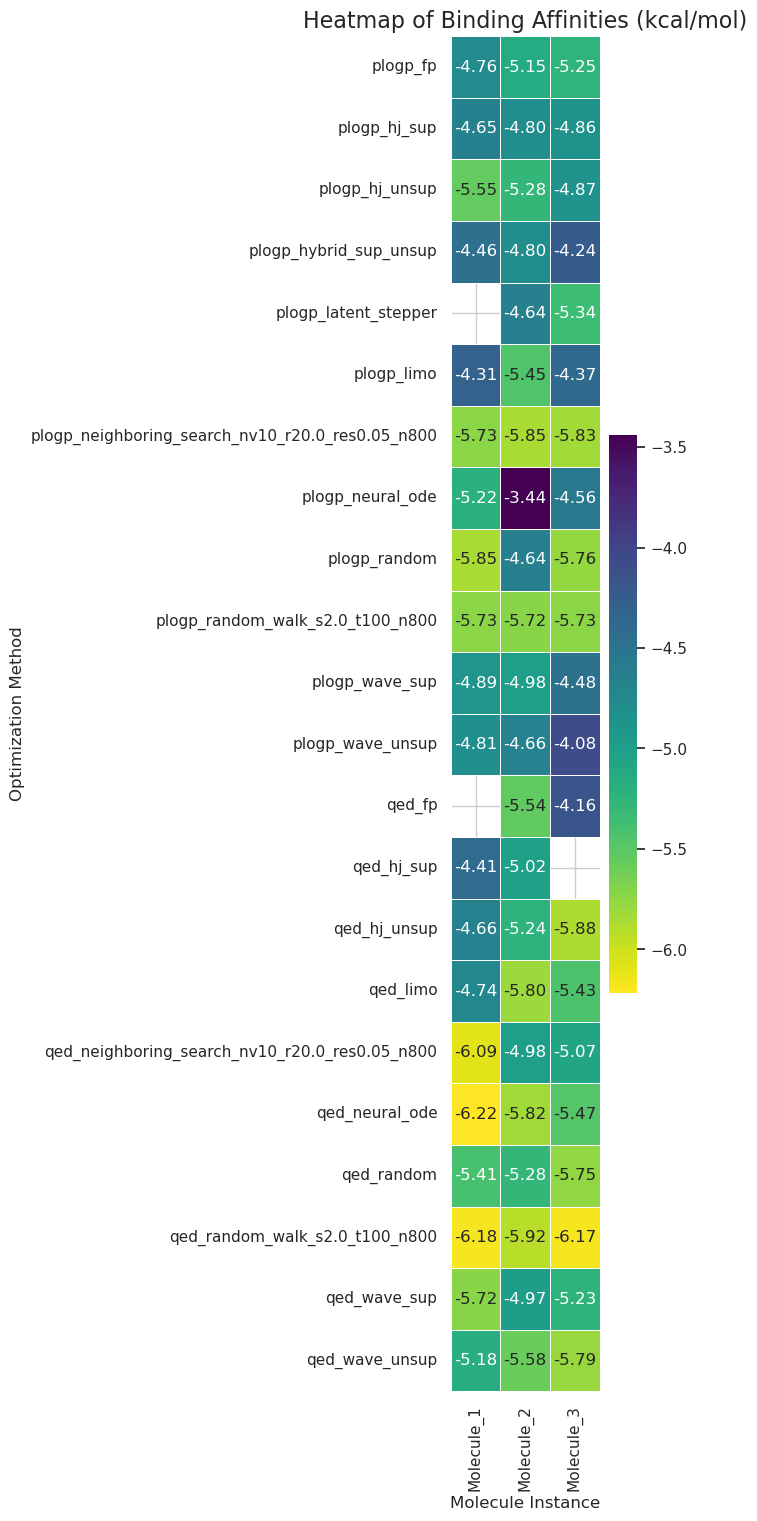

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

def visualize_docking_results(csv_file='results.csv', output_dir='visualizations'):
    """
    Loads docking results from a CSV and generates several plots.
    """
    if not os.path.exists(csv_file):
        print(f"Error: {csv_file} not found. Please run the docking script first.")
        # Create dummy data for demonstration purposes if the file doesn't exist
        print("Creating dummy data for demonstration...")
        data = []
        methods = ['Method_A', 'Method_B', 'Method_C']
        for method in methods:
            for i in range(20):
                hac = np.random.randint(15, 40)
                affinity = -10 + (hac / 20) + np.random.randn() * 0.5 - (2 if method == 'Method_C' else 0)
                data.append({
                    'optimization_method': method,
                    'binding_affinity': affinity,
                    'heavy_atoms': hac,
                    'id': f'mol_{i}'
                })
        df = pd.DataFrame(data)
    else:
        df = pd.read_csv(csv_file)

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    print(f"Saving plots to '{output_dir}/'")

    # Set a consistent style for all plots
    sns.set_theme(style="whitegrid")


    # --- 4. Heatmap ---
    df['molecule_num'] = df.groupby('optimization_method').cumcount()
    pivot_df = df.pivot(index='optimization_method', columns='molecule_num', values='binding_affinity')
    if pivot_df.shape[1] > 30: # Limit columns if there are too many molecules to display
        pivot_df = pivot_df.iloc[:, :30]
        print("Warning: Heatmap truncated to the first 30 molecules for readability.")
    
    pivot_df.columns = [f'Molecule_{i+1}' for i in pivot_df.columns]
    
    plt.figure(figsize=(min(20, pivot_df.shape[1]*0.8), max(6, pivot_df.shape[0]*0.8)))
    sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="viridis_r", linewidths=.5)
    plt.title('Heatmap of Binding Affinities (kcal/mol)', fontsize=16)
    plt.xlabel('Molecule Instance', fontsize=12)
    plt.ylabel('Optimization Method', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'binding_affinity_heatmap.png'))
    plt.show()


if __name__ == '__main__':
    visualize_docking_results(csv_file='results.csv')

In [1]:
from typing import Callable
# import wget

import random
import numpy as np
import matplotlib.pyplot as plt

import torch

from ChemFlow.src.vae import load_vae_demo,load_vae
from ChemFlow.src.pinn.pde import load_wavepde
from ChemFlow.src.pinn import PropGenerator, VAEGenerator
from ChemFlow.src.predictor import Predictor

from rdkit import Chem
from rdkit.Chem import Draw
from tdc import Oracle

SmilesScorer = Callable[[str | list[str]], float | list[float]]

smiles2sa: SmilesScorer = Oracle(name="SA")
smiles2qed: SmilesScorer = Oracle(name="QED")
smiles2plogp: SmilesScorer = Oracle(name="LogP")  
smiles2gsk3b: SmilesScorer = Oracle(name="GSK3B")
smiles2jnk3: SmilesScorer = Oracle(name="JNK3")
smiles2drd2: SmilesScorer = Oracle(name="DRD2")

PROP_FN = {
    "sa": smiles2sa,
    "qed": smiles2qed,
    "plogp": smiles2plogp,
    "gsk3b": smiles2gsk3b,
    "jnk3": smiles2jnk3,
    "drd2": smiles2drd2,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type != "cuda":
    raise ValueError("This notebook requires a GPU")

def normalize(x, step_size=None, relative=False):
    if step_size is None:
        return x
    if relative:
        return x * step_size
    try:
        return x / torch.norm(x, dim=-1, keepdim=True) * step_size
    except AttributeError:
        return x




def get_model(model_name, prop_name, dm, vae):
    """Gets model by name."""

    if model_name == 'Random-1D':
        rand_1d_u_z = torch.zeros(1024).to(device)
        rand_1d_u_z[torch.randint(0, 1024, (1,))] = random.choice([-1, 1])
        return rand_1d_u_z, None
    elif model_name == 'Random':
        rand_u_z = torch.randn(1024, device=device)
        return rand_u_z, None


    predictor = Predictor(dm.max_len * dm.vocab_size)

    prop_name = prop_name.lower()
    predictor.load_state_dict(
        torch.load(
            f"ChemFlow/checkpoints/prop_predictor/{prop_name}/checkpoint.pt", map_location=device
        )
    )

    # print('loaded predictor')
    for p in predictor.parameters():
        p.requires_grad = False

    sup_generator = PropGenerator(vae, predictor).to(device)
    for p in sup_generator.parameters():
        p.requires_grad = False

    unsup_generator = VAEGenerator(vae).to(device)

    unsup_pde = load_wavepde(
        checkpoint=f"ChemFlow/checkpoints/wavepde/zmc/checkpoint.pt",
        generator=unsup_generator,
        k=10,
        device=device,
    )


    # print('loaded unsup pde')
    wave_idx_map = {"plogp": 0, "sa": 6, "qed": 4, "drd2": 2, "jnk3": 0, "gsk3b": 0}
    unsup_pde_idx = wave_idx_map[prop_name]
    for p in unsup_pde.parameters():
        p.requires_grad = False

    sup_pde = load_wavepde(
        checkpoint=f"ChemFlow/checkpoints/wavepde_prop/zmc/{prop_name}/checkpoint.pt",
        generator=sup_generator,
        k=1,
        device=device,
    )


    # print('loaded sup pde')
    sup_pde_idx = 0
    for p in sup_pde.parameters():
        p.requires_grad = False

    if model_name == 'Wave (unsupervised)':
        return unsup_pde, unsup_pde_idx
    elif model_name == 'Wave (supervised)':
        return sup_pde, sup_pde_idx
    elif model_name == 'Gradient Flow' or model_name == 'Langevin Dynamics':
        return sup_pde, None,

    unsup_hj = load_wavepde(
        checkpoint=f"ChemFlow/checkpoints/hjpde/zmc/checkpoint.pt",
        generator=unsup_generator,
        k=10,
        device=device,
    )
    # print('loaded unsup hj')
    hj_idx_map = {"plogp": 5, "sa": 1, "qed": 9, "drd2": 6, "jnk3": 5, "gsk3b": 5}
    unsup_hj_idx = hj_idx_map[prop_name]
    for p in unsup_hj.parameters():
        p.requires_grad = False

    sup_hj = load_wavepde(
        checkpoint=f"ChemFlow/checkpoints/hjpde_prop/zmc/{prop_name}/checkpoint.pt",
        generator=sup_generator,
        k=1,
        device=device,
    )

    # print('loaded sup hj')
    sup_hj_idx = 0
    for p in sup_hj.parameters():
        p.requires_grad = False


    if model_name == 'HJ (unsupervised)':
        return unsup_hj, unsup_hj_idx
    elif model_name == 'HJ (supervised)':
        return sup_hj, sup_hj_idx
    else:
        raise ValueError(f"Invalid model name: {model_name}")



def sample(num_samples=1):
    """Samples latent codes."""
    z0 = torch.randn((num_samples, 1024), device=device)
    return z0


def synthesize_original(_code, _vae, _dm, _device):
    z = _code.clone()
    z = torch.from_numpy(z.detach().cpu().numpy()).float().to(_device)
    x = _vae.decode(z).exp()
    smiles = _dm.decode(x)[0]
    plogp_val = PROP_FN['plogp'](smiles)
    sa_val = PROP_FN['sa'](smiles)
    qed_val = PROP_FN['qed'](smiles)
    drd2_val = PROP_FN['drd2'](smiles)
    jnk3_val = PROP_FN['jnk3'](smiles)
    gsk3b_val = PROP_FN['gsk3b'](smiles)
    label = f'{smiles} \n plogp⬆ {plogp_val:.3f} \n sa⬇ {sa_val:.3f} \n qed⬆ {qed_val:.3f} \n drd2⬆ {drd2_val:.3f} \n jnk3⬆ {jnk3_val:.3f} \n gsk3b⬆ {gsk3b_val:.3f}'
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol, legends=label)
    return img, label


def synthesize_final(_code, _vae, _dm, _device):
    z = torch.from_numpy(_code.detach().cpu().numpy()).float().to(_device)
    x = _vae.decode(z).exp()
    smiles = _dm.decode(x)[0]
    plogp_val = PROP_FN['plogp'](smiles)
    sa_val = PROP_FN['sa'](smiles)
    qed_val = PROP_FN['qed'](smiles)
    drd2_val = PROP_FN['drd2'](smiles)
    jnk3_val = PROP_FN['jnk3'](smiles)
    gsk3b_val = PROP_FN['gsk3b'](smiles)
    label = f'{smiles} \n plogp⬆ {plogp_val:.3f} \n sa⬇ {sa_val:.3f} \n qed⬆ {qed_val:.3f} \n drd2⬆ {drd2_val:.3f} \n jnk3⬆ {jnk3_val:.3f} \n gsk3b⬆ {gsk3b_val:.3f}'
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol, legends=label)
    return img, label

properties = ["plogp", "sa", "qed", "drd2", "jnk3", "gsk3b"]

dm, vae = load_vae(device=device)

/home/akouk/miniconda3/envs/chemflow_gpu/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
Found local copy...
Found local copy...
Found local copy...


Loaded tokenized dataset from ChemFlow/data/processed/zmc_data.pt


Found local copy...


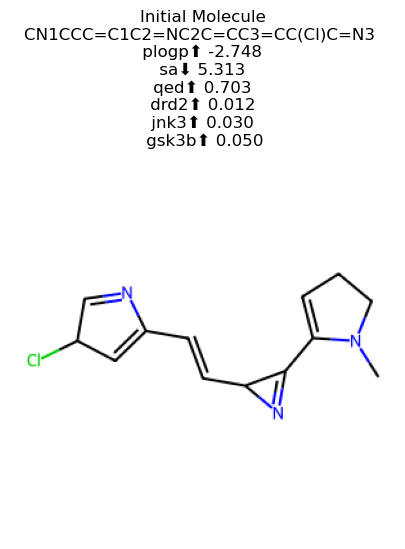

In [2]:
base_codes = sample(num_samples=1)
z = base_codes.clone()

original_image, original_label = synthesize_original(z, vae, dm, device)

plt.figure(figsize=(10, 5))
plt.imshow(original_image)
plt.title('Initial Molecule\n'+original_label)
plt.axis('off')
print('')

Generating a new starting latent code...
Performing initial load of default model ('Wave (unsupervised)')...
Initial model loaded.


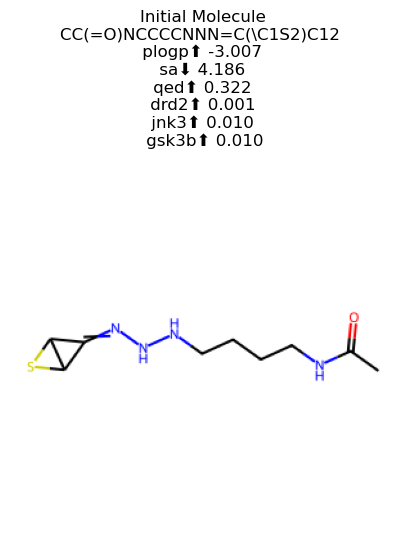

HTML(value='<hr><h3>Adjust Traversal Steps Below</h3>')

Output()

In [4]:
#@title Interactive Molecule Generation Control Panel
# This single cell generates an initial molecule and provides an interactive panel to modify it.

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import time

# --- 1. Generate Starting Point ---
print("Generating a new starting latent code...")
base_codes = sample(num_samples=1)

# --- 2. Perform Initial Model Loading (The Critical Fix) ---
# We must load the default models FIRST to ensure the VAE state is finalized
# before we generate the "Initial Molecule" image.
print("Performing initial load of default model ('Wave (unsupervised)')...")
model_lst = []
default_model_name = 'Wave (unsupervised)'
for prop_name in properties:
    model = get_model(default_model_name, prop_name, dm, vae)
    model_lst.append(model)
current_model_name = default_model_name
print("Initial model loaded.")

# --- 3. Generate and Display the Initial Molecule ---
# Now we generate the initial image using the fully-configured VAE.
original_image, original_label = synthesize_original(base_codes, vae, dm, device)

plt.figure(figsize=(10, 5))
plt.imshow(original_image)
plt.title('Initial Molecule\n' + original_label)
plt.axis('off')
plt.show()

# Add a separator for clarity
display(widgets.HTML("<hr><h3>Adjust Traversal Steps Below</h3>"))


# --- 4. UI Setup for the Interactive Panel ---
model_dropdown = widgets.Dropdown(
    options=['Wave (unsupervised)', 'Wave (supervised)', 'HJ (unsupervised)', 'HJ (supervised)'],
    value=default_model_name, # Start with the model we just loaded
    description='Method:',
    style={'description_width': 'initial'},
)

properties_config = [
    {'prop_name': 'plogp', 'title': 'plogP ↑',   'default': 0},
    {'prop_name': 'sa',    'title': 'SA ↓',      'default': 0},
    {'prop_name': 'qed',   'title': 'QED ↑',     'default': 0},
    {'prop_name': 'drd2',  'title': 'DRD2 ↑',    'default': 0},
    {'prop_name': 'jnk3',  'title': 'JNK3 ↑',    'default': 0},
    {'prop_name': 'gsk3b', 'title': 'GSK3B ↑',   'default': 0},
]

sliders = {
    f"{config['prop_name']}_steps": widgets.IntSlider(
        value=config['default'], min=-10, max=10, step=1,
        description=f"{config['prop_name']}_steps:",
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='60%')
    ) for config in properties_config
}

slider_elements = []
for config in properties_config:
    slider_elements.append(widgets.Label(config['title']))
    slider_elements.append(sliders[f"{config['prop_name']}_steps"])

ui = widgets.VBox([model_dropdown, widgets.HTML("<hr>")] + slider_elements)
output_widget = widgets.Output()


# --- 5. Core Logic Function ---
def update_molecule_ui(model_name, **slider_values):
    global model_lst, current_model_name
    
    with output_widget:
        clear_output(wait=True)

        if model_name != current_model_name:
            print(f"Loading new model: '{model_name}'... (This may take a few minutes)")
            plt.figure(figsize=(1,0.1)); plt.axis('off'); plt.show()
            
            new_model_lst = []
            start_time = time.time()
            for prop_name in properties:
                model = get_model(model_name, prop_name, dm, vae)
                new_model_lst.append(model)
            
            model_lst = new_model_lst
            current_model_name = model_name
            
            clear_output(wait=True)
            print(f"Model '{model_name}' loaded in {time.time() - start_time:.2f} seconds.")

        z = base_codes.clone()
        step_size = 0.05
        relative = True

        for sem_idx, prop_key in enumerate(properties):
            step = slider_values[f"{prop_key}_steps"]
            if step == 0: continue

            total_steps = abs(step)
            for t in range(total_steps):
                model = model_lst[sem_idx]
                
                if current_model_name in ['Wave (unsupervised)', 'Wave (supervised)', 'HJ (unsupervised)', 'HJ (supervised)']:
                    u, u_z = model[0].inference(model[1], z, t % 10)
                    u_z = normalize(u_z, step_size, relative)
                else:
                    raise ValueError(f"Unknown model_name {current_model_name}")

                if properties[sem_idx] in ["sa", "molwt"]: u_z = -u_z
                if step < 0: z = z - u_z
                else: z = z + u_z
        
        final_image, final_label = synthesize_final(z, vae, dm, device)
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set_title('After Traversal:\n' + final_label)
        ax.imshow(final_image)
        ax.axis('off')
        plt.show()

# --- 6. Execution ---
interactive_output = widgets.interactive_output(
    update_molecule_ui,
    {'model_name': model_dropdown, **sliders}
)

display(ui, output_widget)